# SOFIA/FORCAST Galactic Center Combine Fields Notebook

## Preliminary Steps - Select file to use from config.py and load in required packages

In [2]:
#import all required packages
import os
import numpy as np
import re
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import SqrtStretch, simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.io import fits,ascii
from astropy.wcs import WCS
from astropy import units as u
from astropy.stats import sigma_clipped_stats
from astropy.table import join, vstack, Table
from astropy.coordinates import SkyCoord, search_around_sky, Angle
from astropy.nddata import Cutout2D
from astropy.coordinates import SkyCoord

from photutils.aperture import SkyCircularAperture,SkyCircularAnnulus,aperture_photometry 
from photutils.segmentation import detect_threshold, detect_sources, deblend_sources, SourceCatalog
from photutils.background import Background2D, MedianBackground, SExtractorBackground, MMMBackground
from photutils.utils import calc_total_error
from photutils.morphology import data_properties
from photutils import make_source_mask

In [3]:
#new functions needed for this notebook
from astropy.coordinates.matching import _get_cartesian_kdtree

from regions import read_ds9, write_ds9, CircleSkyRegion

In [4]:
#import configuration for selected file
from config import dpath, dpathalt, ds9path #import additional common paramters

from config import *

In [5]:
from FORCASTphot import CombineFieldResults, remove_duplicates, createNames, findNOTindex, makeDS9reg, performApPhoto, modelSources

In [6]:
#change directory to where data is
try:
    os.chdir(dpath)
except:
    os.chdir(dpathalt)

## Combine data files for each field at 25 um

In [7]:
#create initial master catalog at 25 um
mastercat25=CombineFieldResults('CombCat',25)

#add names to mastercat
mastercat25=createNames(mastercat25)

#print the master catalog
mastercat25

finder,xcenter,ycenter,sky_center,aperture_sum_4pix,aperture_sum_err_4pix,aperture_sum_8pix,aperture_sum_err_8pix,aperture_sum_12pix,aperture_sum_err_12pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,bkg_flag,texp_mean,edge_flag,aper_sum_bkgsub_4pix,aper_4pix_noise,aper_snr_4pix,aper_area_4pix,ECF,aper_sum_bkgsub_8pix,aper_8pix_noise,aper_snr_8pix,aper_area_8pix,aper_sum_bkgsub_12pix,aper_12pix_noise,aper_snr_12pix,aper_area_12pix,Field,wv,fwhm,fwhm_err,elong,mfit_x0,mfit_y0,mfit_amp,mfit_gamma,mfit_gamma_err,mfit_alpha,mfit_alpha_err,gfit_x0,gfit_y0,gfit_x0_err,gfit_y0_err,gfit_amp,gfit_xfwhm,gfit_xfwhm_err,gfit_yfwhm,gfit_yfwhm_err,gfit_orient,FluxMoffat2D,FluxMoffatErr,mModelSNR,Moffat2DChi2,FluxGauss2D,FluxGauss2DErr,gModelSNR,Gauss2DChi2,MFitFlag,GFitFlag,"cutouts [25,25]","gresid [17,17]","mresid [17,17]",fit_dist,vexFlag,BestModel,RA(J2000),DEC(J2000),glon,glat,id,sky_centroid,SourceID
,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,float64,float64,float64,float64,int32,bytes1,str12,str13,float64,float64,int64,object,str18
6,250.49631834015173,66.3426982888925,"266.09497709302605,-29.53686745240035",1.5040187824261118,0.10047859269606844,4.22618341079006,0.20602930127861335,6.403125129887702,0.31385377241813783,842.3886568673647,0.0005427765819407151,0.0008950568533467411,0.009816852774640866,0,225.8635376096834,1,1.4754419801861056,0.09842880293121833,14.989941320500858,52.649291054210295,0.02141696521211409,4.111876201830036,0.19685760586243667,20.88756583123031,210.59716421684118,6.145933909727646,0.295286408793655,20.81346694836335,473.84361948789274,Field52,25,11.213179899329152,--,2.340406488748392,8.355502170120138,12.584220632358782,0.038697107678346915,13.001936381174882,1105.295477349902,3.5123141751506597,215.58837927677732,8.211625167705254,16.41130127717924,1.968237583120455,102.31408295268396,0.04324205817773531,7.329648414408793,0.530879837366973,17.154356709326706,36.73971904731816,-3.082298360824518,4.685812555855734,0.20877106467847312,22.444741387281432,2.036411428321837,4.691542103979967,0.2509601542628494,18.694370497820792,1.6269304062303502,0,0,-0.022116731503365714 .. 0.00608160847605871,-0.0108149394367937 .. 0.01036228860314648,-0.011919076417170852 .. 0.005838667749554539,8.41396306071541,0,a,17h44m22.79s,-29d32m12.72s,359.3464408339575,-0.0829354059850822,1,"266.09495833333335,-29.53686666666667",SFGC359.346-0.0829
6,250.60597802727682,73.37081064463712,"266.09495036354866,-29.53536811998432",2.006111164408301,0.08565943133769197,5.071008381582639,0.17996353882181432,7.476068172003422,0.2839276380855657,842.3886568673647,0.00045717975747258264,0.001134365864478208,0.00793625719303421,0,298.8330756229812,1,1.9820409742930338,0.07957298669921284,24.90846525322947,52.649291054210295,0.02141696521211409,4.97472762112157,0.15914597339842568,31.258897192876017,210.59716421684118,7.2594364609660165,0.23871896009763852,30.409970192551242,473.84361948789274,Field52,25,20.0,--,1.0,7.333608479576159,7.700061107419266,0.043795552806109035,12.608954287750759,939.4571209853593,3.618266474269629,215.2973562465596,7.904430382035439,7.712205008621827,3.208437369360635,3.138190829379204,0.08208829729338625,2.1258836429851897e-38,0.9037666648026204,2.1258836429851897e-38,3.046798785387571,--,5.744212843288631,0.16102134356588882,35.67361143610219,1.6652440726932156,--,--,--,--,0,1,0.0025051016351269415 .. 0.00976413170265673,0.007880565135998118 .. 0.0008548068386434697,0.001610479144

In [8]:
#Optional - write 'master' catalogs to fits prior to quality cuts
#mastercat25.write('masterCatComb_FromFields_25um_NoCuts.fits',overwrite=True)

In [9]:
##write out save ds9 region files  - Optional for inspection
##set size of regions 
#r = Angle(2.778E-4*3, u.deg) #must be in degrees - current value is r=3"
##write out ds9 files 
#makeDS9reg('mastercatComb_25um_labelID.reg', mastercat25, r, color='yellow', label="id")
#makeDS9reg('mastercatComb_25um_label4pixSNR.reg', mastercat25, r, color='cyan', label="aper_snr_4pix");
#makeDS9reg('mastercatComb_25um_label8pixSNR.reg', mastercat25, 3*r, color='green', label="aper_snr_8pix");

In [10]:
#remove duplicate sources found in manual checking
rmdup25=np.loadtxt('C:/Users/mhankins1/Desktop/RemoveDup25.dat', dtype=str)

In [11]:
#data checking
for source in rmdup25:
    bid=np.where(mastercat25['SourceID']==source)
    try:
        mastercat25.remove_row(bid[0][0])
    except:
        print('Warning- ', source, ' was not found in table!')
        print('Double check if all source names are correct!\n')

In [12]:
#Now lets look at possible duplications that may exist because of overlapping data coverage
#Automated process - repeat until no likely duplicates are found within 3" search radius
print('Number of sources with duplicates included: ', len(mastercat25))
mastercat25,nduplicats=remove_duplicates(mastercat25, 3.0*u.arcsec)
print('Number of sources with duplicates removed: ', len(mastercat25))

Number of sources with duplicates included:  1199
number of likely duplicates:  286
Number of sources with duplicates removed:  1055


In [13]:
#Now lets look at possible duplications that may exist because of overlapping data coverage
print('Number of sources with duplicates included: ', len(mastercat25))
mastercat25,nduplicates=remove_duplicates(mastercat25, 3.0*u.arcsec)
print('Number of sources with duplicates removed: ', len(mastercat25))

Number of sources with duplicates included:  1055
number of likely duplicates:  16
Number of sources with duplicates removed:  1047


In [14]:
#Now lets look at possible duplications that may exist because of overlapping data coverage
print('Number of sources with duplicates included: ', len(mastercat25))
mastercat25,nduplicates=remove_duplicates(mastercat25, 3.0*u.arcsec)
print('Number of sources with duplicates removed: ', len(mastercat25))

Number of sources with duplicates included:  1047
number of likely duplicates:  0
Number of sources with duplicates removed:  1047


In [15]:
#write out save ds9 region files - optional for testing
#makeDS9reg('mastercat_noDuplicates_25um_labelID.reg', mastercat25, r, color='magenta', label="id");

In [16]:
mastercat25

finder,xcenter,ycenter,sky_center,aperture_sum_4pix,aperture_sum_err_4pix,aperture_sum_8pix,aperture_sum_err_8pix,aperture_sum_12pix,aperture_sum_err_12pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,bkg_flag,texp_mean,edge_flag,aper_sum_bkgsub_4pix,aper_4pix_noise,aper_snr_4pix,aper_area_4pix,ECF,aper_sum_bkgsub_8pix,aper_8pix_noise,aper_snr_8pix,aper_area_8pix,aper_sum_bkgsub_12pix,aper_12pix_noise,aper_snr_12pix,aper_area_12pix,Field,wv,fwhm,fwhm_err,elong,mfit_x0,mfit_y0,mfit_amp,mfit_gamma,mfit_gamma_err,mfit_alpha,mfit_alpha_err,gfit_x0,gfit_y0,gfit_x0_err,gfit_y0_err,gfit_amp,gfit_xfwhm,gfit_xfwhm_err,gfit_yfwhm,gfit_yfwhm_err,gfit_orient,FluxMoffat2D,FluxMoffatErr,mModelSNR,Moffat2DChi2,FluxGauss2D,FluxGauss2DErr,gModelSNR,Gauss2DChi2,MFitFlag,GFitFlag,"cutouts [25,25]","gresid [17,17]","mresid [17,17]",fit_dist,vexFlag,BestModel,RA(J2000),DEC(J2000),glon,glat,id,sky_centroid,SourceID,selfXmatch
,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,float64,float64,float64,float64,int32,bytes1,str12,str13,float64,float64,int64,object,str18,int64
6,250.49631834015173,66.3426982888925,"266.09497709302605,-29.53686745240035",1.5040187824261118,0.10047859269606844,4.22618341079006,0.20602930127861335,6.403125129887702,0.31385377241813783,842.3886568673647,0.0005427765819407151,0.0008950568533467411,0.009816852774640866,0,225.8635376096834,1,1.4754419801861056,0.09842880293121833,14.989941320500858,52.649291054210295,0.02141696521211409,4.111876201830036,0.19685760586243667,20.88756583123031,210.59716421684118,6.145933909727646,0.295286408793655,20.81346694836335,473.84361948789274,Field52,25,11.213179899329152,--,2.340406488748392,8.355502170120138,12.584220632358782,0.038697107678346915,13.001936381174882,1105.295477349902,3.5123141751506597,215.58837927677732,8.211625167705254,16.41130127717924,1.968237583120455,102.31408295268396,0.04324205817773531,7.329648414408793,0.530879837366973,17.154356709326706,36.73971904731816,-3.082298360824518,4.685812555855734,0.20877106467847312,22.444741387281432,2.036411428321837,4.691542103979967,0.2509601542628494,18.694370497820792,1.6269304062303502,0,0,-0.022116731503365714 .. 0.00608160847605871,-0.0108149394367937 .. 0.01036228860314648,-0.011919076417170852 .. 0.005838667749554539,8.41396306071541,0,a,17h44m22.79s,-29d32m12.72s,359.3464408339575,-0.0829354059850822,1,"266.09495833333335,-29.53686666666667",SFGC359.346-0.0829,0
6,250.60597802727682,73.37081064463712,"266.09495036354866,-29.53536811998432",2.006111164408301,0.08565943133769197,5.071008381582639,0.17996353882181432,7.476068172003422,0.2839276380855657,842.3886568673647,0.00045717975747258264,0.001134365864478208,0.00793625719303421,0,298.8330756229812,1,1.9820409742930338,0.07957298669921284,24.90846525322947,52.649291054210295,0.02141696521211409,4.97472762112157,0.15914597339842568,31.258897192876017,210.59716421684118,7.2594364609660165,0.23871896009763852,30.409970192551242,473.84361948789274,Field52,25,20.0,--,1.0,7.333608479576159,7.700061107419266,0.043795552806109035,12.608954287750759,939.4571209853593,3.618266474269629,215.2973562465596,7.904430382035439,7.712205008621827,3.208437369360635,3.138190829379204,0.08208829729338625,2.1258836429851897e-38,0.9037666648026204,2.1258836429851897e-38,3.046798785387571,--,5.744212843288631,0.16102134356588882,35.67361143610219,1.6652440726932156,--,--,--,--,0,1,0.0025051016351269415 .. 0.00976413170265673,0.007880565135998118 .. 0.00085480683864

### Apply Quality Cuts

In [17]:
#First check if there are masked elements before applying SNR cut - if false - don't worry, if true - investigate any masked values
np.ma.getmask(mastercat25['aper_snr_8pix'])

False

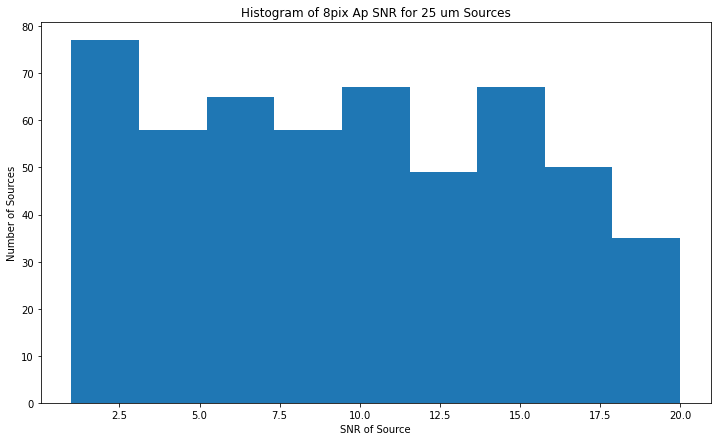

In [18]:
#now lets look at SNR distrobution of the catalog sources
binlist=np.linspace(1,20,10)

plt.figure(figsize=(12,7))
plt.title('Histogram of 8pix Ap SNR for 25 um Sources')
plt.hist(mastercat25['aper_snr_8pix'],bins=binlist)
plt.xlabel('SNR of Source')
plt.ylabel('Number of Sources')
#plt.xlim(0,25)
plt.show()


In [19]:
#write out save ds9 region files - optional for testing and examining individual sources
#makeDS9reg('mastercat_25um_SNR4update.reg', mastercat25, 1.25*r, color='cyan', label="aper_snr_4pix"); 
#makeDS9reg('mastercat_25um_SNR8update.reg', mastercat25, 1.5*r, color='yellow', label="aper_snr_8pix"); 
#makeDS9reg('mastercat_25um_SNR4update.reg', update25, 1*r, color='cyan', label="aper_snr_4pix"); 

In [20]:
#lets examine SNR cut - From visual inspection, all reasonable looking sources have at least SNR 3. 
snrcut4pix=mastercat25['aper_snr_4pix']>=3.0
snrcut8pix=mastercat25['aper_snr_8pix']>=3.0
snrcut=np.logical_or(snrcut4pix,snrcut8pix)

mcat25snrcut=mastercat25[snrcut] #apply snr cut

print("Number of Catalog Sources after SNR cut: ", len(mcat25snrcut))

Number of Catalog Sources after SNR cut:  863


In [21]:
mcat25snrcut

finder,xcenter,ycenter,sky_center,aperture_sum_4pix,aperture_sum_err_4pix,aperture_sum_8pix,aperture_sum_err_8pix,aperture_sum_12pix,aperture_sum_err_12pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,bkg_flag,texp_mean,edge_flag,aper_sum_bkgsub_4pix,aper_4pix_noise,aper_snr_4pix,aper_area_4pix,ECF,aper_sum_bkgsub_8pix,aper_8pix_noise,aper_snr_8pix,aper_area_8pix,aper_sum_bkgsub_12pix,aper_12pix_noise,aper_snr_12pix,aper_area_12pix,Field,wv,fwhm,fwhm_err,elong,mfit_x0,mfit_y0,mfit_amp,mfit_gamma,mfit_gamma_err,mfit_alpha,mfit_alpha_err,gfit_x0,gfit_y0,gfit_x0_err,gfit_y0_err,gfit_amp,gfit_xfwhm,gfit_xfwhm_err,gfit_yfwhm,gfit_yfwhm_err,gfit_orient,FluxMoffat2D,FluxMoffatErr,mModelSNR,Moffat2DChi2,FluxGauss2D,FluxGauss2DErr,gModelSNR,Gauss2DChi2,MFitFlag,GFitFlag,"cutouts [25,25]","gresid [17,17]","mresid [17,17]",fit_dist,vexFlag,BestModel,RA(J2000),DEC(J2000),glon,glat,id,sky_centroid,SourceID,selfXmatch
,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,float64,float64,float64,float64,int32,bytes1,str12,str13,float64,float64,int64,object,str18,int64
6,250.49631834015173,66.3426982888925,"266.09497709302605,-29.53686745240035",1.5040187824261118,0.10047859269606844,4.22618341079006,0.20602930127861335,6.403125129887702,0.31385377241813783,842.3886568673647,0.0005427765819407151,0.0008950568533467411,0.009816852774640866,0,225.8635376096834,1,1.4754419801861056,0.09842880293121833,14.989941320500858,52.649291054210295,0.02141696521211409,4.111876201830036,0.19685760586243667,20.88756583123031,210.59716421684118,6.145933909727646,0.295286408793655,20.81346694836335,473.84361948789274,Field52,25,11.213179899329152,--,2.340406488748392,8.355502170120138,12.584220632358782,0.038697107678346915,13.001936381174882,1105.295477349902,3.5123141751506597,215.58837927677732,8.211625167705254,16.41130127717924,1.968237583120455,102.31408295268396,0.04324205817773531,7.329648414408793,0.530879837366973,17.154356709326706,36.73971904731816,-3.082298360824518,4.685812555855734,0.20877106467847312,22.444741387281432,2.036411428321837,4.691542103979967,0.2509601542628494,18.694370497820792,1.6269304062303502,0,0,-0.022116731503365714 .. 0.00608160847605871,-0.0108149394367937 .. 0.01036228860314648,-0.011919076417170852 .. 0.005838667749554539,8.41396306071541,0,a,17h44m22.79s,-29d32m12.72s,359.3464408339575,-0.0829354059850822,1,"266.09495833333335,-29.53686666666667",SFGC359.346-0.0829,0
6,250.60597802727682,73.37081064463712,"266.09495036354866,-29.53536811998432",2.006111164408301,0.08565943133769197,5.071008381582639,0.17996353882181432,7.476068172003422,0.2839276380855657,842.3886568673647,0.00045717975747258264,0.001134365864478208,0.00793625719303421,0,298.8330756229812,1,1.9820409742930338,0.07957298669921284,24.90846525322947,52.649291054210295,0.02141696521211409,4.97472762112157,0.15914597339842568,31.258897192876017,210.59716421684118,7.2594364609660165,0.23871896009763852,30.409970192551242,473.84361948789274,Field52,25,20.0,--,1.0,7.333608479576159,7.700061107419266,0.043795552806109035,12.608954287750759,939.4571209853593,3.618266474269629,215.2973562465596,7.904430382035439,7.712205008621827,3.208437369360635,3.138190829379204,0.08208829729338625,2.1258836429851897e-38,0.9037666648026204,2.1258836429851897e-38,3.046798785387571,--,5.744212843288631,0.16102134356588882,35.67361143610219,1.6652440726932156,--,--,--,--,0,1,0.0025051016351269415 .. 0.00976413170265673,0.007880565135998118 .. 0.00085480683864

In [22]:
#write out save file for the testingsources notebook (optional)
mcat25snrcut.write('masterCatComb_FromFields_25um_wSNRcut.fits',overwrite=True)

In [23]:
#import bad source list from visual checking
vbs25=np.loadtxt('C:/Users/mhankins1/Desktop/visualBadSources25.dat', dtype=str)

In [24]:
#remove bad sources from file defined above
verbose=0
for source in vbs25:
    bid=np.where(mcat25snrcut['SourceID']==source)
    try:
        mcat25snrcut.remove_row(bid[0][0])
    except:
        if verbose==1:
            print('Warning- ', source, ' was not found in table!')
            print('Double check if all source names are correct!\n')

In [25]:
mcat25snrcut

finder,xcenter,ycenter,sky_center,aperture_sum_4pix,aperture_sum_err_4pix,aperture_sum_8pix,aperture_sum_err_8pix,aperture_sum_12pix,aperture_sum_err_12pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,bkg_flag,texp_mean,edge_flag,aper_sum_bkgsub_4pix,aper_4pix_noise,aper_snr_4pix,aper_area_4pix,ECF,aper_sum_bkgsub_8pix,aper_8pix_noise,aper_snr_8pix,aper_area_8pix,aper_sum_bkgsub_12pix,aper_12pix_noise,aper_snr_12pix,aper_area_12pix,Field,wv,fwhm,fwhm_err,elong,mfit_x0,mfit_y0,mfit_amp,mfit_gamma,mfit_gamma_err,mfit_alpha,mfit_alpha_err,gfit_x0,gfit_y0,gfit_x0_err,gfit_y0_err,gfit_amp,gfit_xfwhm,gfit_xfwhm_err,gfit_yfwhm,gfit_yfwhm_err,gfit_orient,FluxMoffat2D,FluxMoffatErr,mModelSNR,Moffat2DChi2,FluxGauss2D,FluxGauss2DErr,gModelSNR,Gauss2DChi2,MFitFlag,GFitFlag,"cutouts [25,25]","gresid [17,17]","mresid [17,17]",fit_dist,vexFlag,BestModel,RA(J2000),DEC(J2000),glon,glat,id,sky_centroid,SourceID,selfXmatch
,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,float64,float64,float64,float64,int32,bytes1,str12,str13,float64,float64,int64,object,str18,int64
6,250.49631834015173,66.3426982888925,"266.09497709302605,-29.53686745240035",1.5040187824261118,0.10047859269606844,4.22618341079006,0.20602930127861335,6.403125129887702,0.31385377241813783,842.3886568673647,0.0005427765819407151,0.0008950568533467411,0.009816852774640866,0,225.8635376096834,1,1.4754419801861056,0.09842880293121833,14.989941320500858,52.649291054210295,0.02141696521211409,4.111876201830036,0.19685760586243667,20.88756583123031,210.59716421684118,6.145933909727646,0.295286408793655,20.81346694836335,473.84361948789274,Field52,25,11.213179899329152,--,2.340406488748392,8.355502170120138,12.584220632358782,0.038697107678346915,13.001936381174882,1105.295477349902,3.5123141751506597,215.58837927677732,8.211625167705254,16.41130127717924,1.968237583120455,102.31408295268396,0.04324205817773531,7.329648414408793,0.530879837366973,17.154356709326706,36.73971904731816,-3.082298360824518,4.685812555855734,0.20877106467847312,22.444741387281432,2.036411428321837,4.691542103979967,0.2509601542628494,18.694370497820792,1.6269304062303502,0,0,-0.022116731503365714 .. 0.00608160847605871,-0.0108149394367937 .. 0.01036228860314648,-0.011919076417170852 .. 0.005838667749554539,8.41396306071541,0,a,17h44m22.79s,-29d32m12.72s,359.3464408339575,-0.0829354059850822,1,"266.09495833333335,-29.53686666666667",SFGC359.346-0.0829,0
6,250.60597802727682,73.37081064463712,"266.09495036354866,-29.53536811998432",2.006111164408301,0.08565943133769197,5.071008381582639,0.17996353882181432,7.476068172003422,0.2839276380855657,842.3886568673647,0.00045717975747258264,0.001134365864478208,0.00793625719303421,0,298.8330756229812,1,1.9820409742930338,0.07957298669921284,24.90846525322947,52.649291054210295,0.02141696521211409,4.97472762112157,0.15914597339842568,31.258897192876017,210.59716421684118,7.2594364609660165,0.23871896009763852,30.409970192551242,473.84361948789274,Field52,25,20.0,--,1.0,7.333608479576159,7.700061107419266,0.043795552806109035,12.608954287750759,939.4571209853593,3.618266474269629,215.2973562465596,7.904430382035439,7.712205008621827,3.208437369360635,3.138190829379204,0.08208829729338625,2.1258836429851897e-38,0.9037666648026204,2.1258836429851897e-38,3.046798785387571,--,5.744212843288631,0.16102134356588882,35.67361143610219,1.6652440726932156,--,--,--,--,0,1,0.0025051016351269415 .. 0.00976413170265673,0.007880565135998118 .. 0.00085480683864

In [26]:
#rename table file for later parts of code
update25=mcat25snrcut

len(update25)

715

In [27]:
update25

finder,xcenter,ycenter,sky_center,aperture_sum_4pix,aperture_sum_err_4pix,aperture_sum_8pix,aperture_sum_err_8pix,aperture_sum_12pix,aperture_sum_err_12pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,bkg_flag,texp_mean,edge_flag,aper_sum_bkgsub_4pix,aper_4pix_noise,aper_snr_4pix,aper_area_4pix,ECF,aper_sum_bkgsub_8pix,aper_8pix_noise,aper_snr_8pix,aper_area_8pix,aper_sum_bkgsub_12pix,aper_12pix_noise,aper_snr_12pix,aper_area_12pix,Field,wv,fwhm,fwhm_err,elong,mfit_x0,mfit_y0,mfit_amp,mfit_gamma,mfit_gamma_err,mfit_alpha,mfit_alpha_err,gfit_x0,gfit_y0,gfit_x0_err,gfit_y0_err,gfit_amp,gfit_xfwhm,gfit_xfwhm_err,gfit_yfwhm,gfit_yfwhm_err,gfit_orient,FluxMoffat2D,FluxMoffatErr,mModelSNR,Moffat2DChi2,FluxGauss2D,FluxGauss2DErr,gModelSNR,Gauss2DChi2,MFitFlag,GFitFlag,"cutouts [25,25]","gresid [17,17]","mresid [17,17]",fit_dist,vexFlag,BestModel,RA(J2000),DEC(J2000),glon,glat,id,sky_centroid,SourceID,selfXmatch
,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,float64,float64,float64,float64,int32,bytes1,str12,str13,float64,float64,int64,object,str18,int64
6,250.49631834015173,66.3426982888925,"266.09497709302605,-29.53686745240035",1.5040187824261118,0.10047859269606844,4.22618341079006,0.20602930127861335,6.403125129887702,0.31385377241813783,842.3886568673647,0.0005427765819407151,0.0008950568533467411,0.009816852774640866,0,225.8635376096834,1,1.4754419801861056,0.09842880293121833,14.989941320500858,52.649291054210295,0.02141696521211409,4.111876201830036,0.19685760586243667,20.88756583123031,210.59716421684118,6.145933909727646,0.295286408793655,20.81346694836335,473.84361948789274,Field52,25,11.213179899329152,--,2.340406488748392,8.355502170120138,12.584220632358782,0.038697107678346915,13.001936381174882,1105.295477349902,3.5123141751506597,215.58837927677732,8.211625167705254,16.41130127717924,1.968237583120455,102.31408295268396,0.04324205817773531,7.329648414408793,0.530879837366973,17.154356709326706,36.73971904731816,-3.082298360824518,4.685812555855734,0.20877106467847312,22.444741387281432,2.036411428321837,4.691542103979967,0.2509601542628494,18.694370497820792,1.6269304062303502,0,0,-0.022116731503365714 .. 0.00608160847605871,-0.0108149394367937 .. 0.01036228860314648,-0.011919076417170852 .. 0.005838667749554539,8.41396306071541,0,a,17h44m22.79s,-29d32m12.72s,359.3464408339575,-0.0829354059850822,1,"266.09495833333335,-29.53686666666667",SFGC359.346-0.0829,0
6,250.60597802727682,73.37081064463712,"266.09495036354866,-29.53536811998432",2.006111164408301,0.08565943133769197,5.071008381582639,0.17996353882181432,7.476068172003422,0.2839276380855657,842.3886568673647,0.00045717975747258264,0.001134365864478208,0.00793625719303421,0,298.8330756229812,1,1.9820409742930338,0.07957298669921284,24.90846525322947,52.649291054210295,0.02141696521211409,4.97472762112157,0.15914597339842568,31.258897192876017,210.59716421684118,7.2594364609660165,0.23871896009763852,30.409970192551242,473.84361948789274,Field52,25,20.0,--,1.0,7.333608479576159,7.700061107419266,0.043795552806109035,12.608954287750759,939.4571209853593,3.618266474269629,215.2973562465596,7.904430382035439,7.712205008621827,3.208437369360635,3.138190829379204,0.08208829729338625,2.1258836429851897e-38,0.9037666648026204,2.1258836429851897e-38,3.046798785387571,--,5.744212843288631,0.16102134356588882,35.67361143610219,1.6652440726932156,--,--,--,--,0,1,0.0025051016351269415 .. 0.00976413170265673,0.007880565135998118 .. 0.00085480683864

In [29]:
#Optional - write 'master' catalogs to fits prior to quality cuts
update25.write('masterCat_25um_Step3.fits',overwrite=True)

## Testing items below - data checking for 25 um catalog

In [30]:
##write out save ds9 region files - optional for testing
#makeDS9reg('mastercat_25um_Step3_labelID.reg', update25, r*1.0, color='cyan', label="id");

##write out save ds9 region files - optional for testing
#makeDS9reg('mastercat_25um_SNR4update.reg', mastercat25, 1*r, color='cyan', label="aper_snr_4pix"); 
#makeDS9reg('mastercat_25um_SNR8update.reg', mastercat25, 1.5*r, color='yellow', label="aper_snr_8pix"); 
#makeDS9reg('mastercat_25um_SNR4update.reg', update25, 1*r, color='cyan', label="aper_snr_4pix"); 

#makeDS9reg('flux8pix.reg', update25, r*5.0, color='cyan', label="aper_sum_bkgsub_8pix"); 
#makeDS9reg('EdgeFlag25.reg', update25, r*3.0, color='cyan', label="texp_mean"); 

In [31]:
##for testing - get source ID for masking based on numeric ID 
#bid=np.where(mastercat25['id']==689) #329 - SFGC359.943-0.0441 cnr minispiral
#mastercat25[bid]['SourceID']
#mastercat25[bid]['aper_snr_8pix']

In [32]:
##for testing - get source ID for masking based on numeric ID 
#bid=np.where(update25['id']==1044)
#update25[bid]['SourceID']
#bid=np.where(mastercat25['id']==439)  #774
#mastercat25[bid]['ann_bkg_std']

In [33]:
##check for masked data in columns
#np.ma.is_masked(mastercat25[mastercat25['GFitFlag']==0]['fwhm'])
#mastercat25[mastercat25['GFitFlag']==0]

## Now move on to 37 um data

In [34]:
#create initial master catalog at 37 um
mastercat37=CombineFieldResults('CombCat',37)

#add names to mastercat
mastercat37=createNames(mastercat37)

#print the master catalog
mastercat37

finder,xcenter,ycenter,sky_center,aperture_sum_5.5pix,aperture_sum_err_5.5pix,aperture_sum_10.5pix,aperture_sum_err_10.5pix,aperture_sum_14pix,aperture_sum_err_14pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,bkg_flag,texp_mean,edge_flag,aper_sum_bkgsub_5.5pix,aper_5.5pix_noise,aper_snr_5.5pix,aper_area_5.5pix,ECF,aper_sum_bkgsub_10.5pix,aper_10.5pix_noise,aper_snr_10.5pix,aper_area_10.5pix,aper_sum_bkgsub_14pix,aper_14pix_noise,aper_snr_14pix,aper_area_14pix,Field,wv,fwhm,fwhm_err,elong,mfit_x0,mfit_y0,mfit_amp,mfit_gamma,mfit_gamma_err,mfit_alpha,mfit_alpha_err,gfit_x0,gfit_y0,gfit_x0_err,gfit_y0_err,gfit_amp,gfit_xfwhm,gfit_xfwhm_err,gfit_yfwhm,gfit_yfwhm_err,gfit_orient,FluxMoffat2D,FluxMoffatErr,mModelSNR,Moffat2DChi2,FluxGauss2D,FluxGauss2DErr,gModelSNR,Gauss2DChi2,MFitFlag,GFitFlag,"cutouts [31,31]","gresid [17,17]","mresid [17,17]",fit_dist,vexFlag,BestModel,RA(J2000),DEC(J2000),glon,glat,id,sky_centroid,SourceID
,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,float64,float64,float64,float64,int32,bytes1,str12,str13,float64,float64,int64,object,str18
1,219.67261882796333,33.377003418940035,"266.1005841,-29.5450055",-0.18572890972655867,0.2592436145516693,-0.1279626269438423,0.5060518619506639,-1.9437934820969998,0.6866219811971755,947.6871944902596,-0.0033212123457438854,-0.006714190813179509,0.016659155097641598,0,193.277260093662,1,0.14486477051612953,0.22967070059566375,0.6307498960050834,99.54006122684149,0.028263993207497874,1.0769283894778556,0.4384622465917217,2.4561485004674704,362.7865041408023,0.19823499154157448,0.5846163287889622,0.33908562210744264,644.9537851392042,Field52,37,26.0,--,13.963733149156976,7.504400558801861,8.255915985545402,-0.023378977808699516,29.716078537093814,19609364217.980347,786.9170887865644,54784167470597.85,7.4746327721824315,5.459638854765918,12542222529.798708,28866083280.70007,-0.14149528485215124,5.887236226795789,5775044731.75146,0.4216090470871835,198365523285.85455,--,-0.08252150028486473,0.05146159881205672,-1.6035549261934536,1.268249595410059,--,--,--,--,0,1,0.03113393391037297 .. -0.00146766221094581,-0.009147827034810112 .. -0.003041745954676635,-0.009147827034810112 .. -0.003041745954676635,2.594117474649083,0,a,17h44m24.14s,-29d32m42.02s,359.34205828523227,-0.09135069864983418,1,"266.1005833333333,-29.545005555555562",SFGC359.342-0.0914
1,243.13892382711222,68.15571648753132,"266.0948305,-29.5375857",5.194867532909158,0.21355213571441184,14.670180642902116,0.42061638501220777,21.426791326103974,0.5790208629303778,947.6871944902596,0.0045447010221959135,0.0055499148319555465,0.01465648876601892,0,292.0386602182828,1,4.742487714902088,0.20206103031243056,23.47057078531751,99.54006122684149,0.028263993207497874,13.021424446694528,0.3857528760510038,33.75587132362132,362.7865041408023,18.495669199512708,0.514337168068005,35.96020343812142,644.9537851392042,Field52,37,17.764314839295384,--,3.0543059060691635,8.376641555192302,8.864226895185748,0.07431845211142424,1.823723468452101,13.95009109438636,0.2881678344682201,0.0717019487578874,8.347017355685114,12.521121419495994,1.6089377407725822,165.9659113338139,0.05533361465802119,10.164644535097324,0.9233460234073779,31.045933836641403,414.56756069705,-3.0845168154631866,10.728866529963614,0.29721180533938585,36.09838619200315,1.7585013380229995,10.707865496184844,0.5935838906502212,18.039346526832592,1.3584998612756638,0,0,0.0039100279167060695 .. 0.022557043883665577,0.010638885575901657 .. 0.0

In [35]:
#Optional - write 'master' catalogs to fits prior to quality cuts
#mastercat37.write('masterCatComb_FromFields_37um_NoCuts.fits',overwrite=True)

In [36]:
##write out save ds9 region files  - Optional for inspection
##set size of regions 
#r = Angle(0.00083333, u.deg) #must be in degrees - current value is r=3"
##write out ds9 files
#makeDS9reg('mastercatComb_37um_labelID.reg', mastercat37, r, color='red', label="id");
#makeDS9reg('mastercatComb_37um_label5pixSNR.reg', mastercat37, r, color='magenta', label="aper_snr_5.5pix");
#makeDS9reg('mastercatComb_37um_label10pixSNR.reg', mastercat37, 3*r, color='yellow', label="aper_snr_10.5pix");

In [37]:
#remove duplicate sources found in manual checking
rmdup37=np.loadtxt('C:/Users/mhankins1/Desktop/RemoveDup37.dat', dtype=str)

In [38]:
#remove duplicate sources found in manual checking
verbose = 0
for source in rmdup37:
    bid=np.where(mastercat37['SourceID']==source)
    try:
        mastercat37.remove_row(bid[0][0])
    except:
        if verbose == 1:
            print('Warning- ', source, ' was not found in table!')
            print('Double check if all source names are correct!\n')

In [39]:
#Now lets look at possible duplications that may exist because of overlapping data coverage
#Automated process - repeat until no likely duplicates are found within 3" search radius
print('Number of sources with duplicates included', len(mastercat37))
mastercat37,removed=remove_duplicates(mastercat37, 3.0*u.arcsec)
print('Number of sources with duplicates removed', len(mastercat37))

Number of sources with duplicates included 1079
number of likely duplicates:  251
Number of sources with duplicates removed 952


In [40]:
#Now lets look at possible duplications that may exist because of overlapping data coverage
print('Number of sources with duplicates included', len(mastercat37))
mastercat37,removed=remove_duplicates(mastercat37, 3.0*u.arcsec)
print('Number of sources with duplicates removed', len(mastercat37))

Number of sources with duplicates included 952
number of likely duplicates:  11
Number of sources with duplicates removed 947


In [41]:
#Now lets look at possible duplications that may exist because of overlapping data coverage
print('Number of sources with duplicates included', len(mastercat37))
mastercat37,removed=remove_duplicates(mastercat37, 3.0*u.arcsec)
print('Number of sources with duplicates removed', len(mastercat37))

Number of sources with duplicates included 947
number of likely duplicates:  2
Number of sources with duplicates removed 946


In [42]:
#Now lets look at possible duplications that may exist because of overlapping data coverage
print('Number of sources with duplicates included', len(mastercat37))
mastercat37,removed=remove_duplicates(mastercat37, 3.0*u.arcsec)
print('Number of sources with duplicates removed', len(mastercat37))

Number of sources with duplicates included 946
number of likely duplicates:  0
Number of sources with duplicates removed 946


In [43]:
#write 'master' catalogs to fits - optional for testing
#mastercat37.write('masterCat_FromFields_noDuplicates_37um.fits',overwrite=True)

In [44]:
#write out save ds9 region files - optional for testing
#makeDS9reg('mastercat_noDuplicates_37um_labelID.reg', mastercat37, r, color='magenta', label="id");

### Quality Cuts

In [45]:
#check if there are masked elements before applying cut
np.ma.getmask(mastercat37['aper_snr_10.5pix'])

False

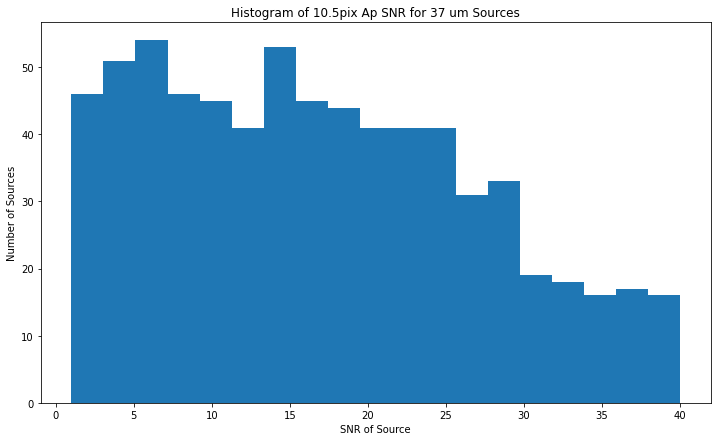

In [46]:
#now lets look at SNR distrobution for 37 micron sources
binlist=np.linspace(1,40,20)

plt.figure(figsize=(12,7))
plt.title('Histogram of 10.5pix Ap SNR for 37 um Sources')
plt.hist(mastercat37['aper_snr_10.5pix'],bins=binlist)
plt.xlabel('SNR of Source')
plt.ylabel('Number of Sources')
#plt.xlim(0,25)
plt.show()


In [47]:
#lets examine SNR cuts...
snrcut5pix=mastercat37['aper_snr_5.5pix']>=3.0
snrcut10pix=mastercat37['aper_snr_10.5pix']>=3.0
snrcut=np.logical_or(snrcut5pix,snrcut10pix)

mcat37snrcut=mastercat37[snrcut] #apply snr cut

print("Number of Catalog Sources after SNR cut: ", len(mcat37snrcut))

Number of Catalog Sources after SNR cut:  815


In [49]:
#write out save file for the testingsources notebook (optional)
mcat37snrcut.write('masterCatComb_FromFields_37um_wSNRcut.fits',overwrite=True)

In [50]:
# load in 'bad' source list from visual inspection of catalog cutouts
vbs37=np.loadtxt('C:/Users/mhankins1/Desktop/visualBadSources37.dat', dtype=str)

In [51]:
#remove bad sources from visual vetting
verbose=0
for source in vbs37:
    bid=np.where(mcat37snrcut['SourceID']==source)
    try:
        mcat37snrcut.remove_row(bid[0][0])
    except:
        if verbose == 1:
            print('Warning- ', source, ' was not found in table!')
            print('Double check if all source names are correct!\n')

In [52]:
#update name of 37 micron source table for later parts of code
update37 = mcat37snrcut

In [53]:
#print table
update37

finder,xcenter,ycenter,sky_center,aperture_sum_5.5pix,aperture_sum_err_5.5pix,aperture_sum_10.5pix,aperture_sum_err_10.5pix,aperture_sum_14pix,aperture_sum_err_14pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,bkg_flag,texp_mean,edge_flag,aper_sum_bkgsub_5.5pix,aper_5.5pix_noise,aper_snr_5.5pix,aper_area_5.5pix,ECF,aper_sum_bkgsub_10.5pix,aper_10.5pix_noise,aper_snr_10.5pix,aper_area_10.5pix,aper_sum_bkgsub_14pix,aper_14pix_noise,aper_snr_14pix,aper_area_14pix,Field,wv,fwhm,fwhm_err,elong,mfit_x0,mfit_y0,mfit_amp,mfit_gamma,mfit_gamma_err,mfit_alpha,mfit_alpha_err,gfit_x0,gfit_y0,gfit_x0_err,gfit_y0_err,gfit_amp,gfit_xfwhm,gfit_xfwhm_err,gfit_yfwhm,gfit_yfwhm_err,gfit_orient,FluxMoffat2D,FluxMoffatErr,mModelSNR,Moffat2DChi2,FluxGauss2D,FluxGauss2DErr,gModelSNR,Gauss2DChi2,MFitFlag,GFitFlag,"cutouts [31,31]","gresid [17,17]","mresid [17,17]",fit_dist,vexFlag,BestModel,RA(J2000),DEC(J2000),glon,glat,id,sky_centroid,SourceID,selfXmatch
,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,float64,float64,float64,float64,int32,bytes1,str12,str13,float64,float64,int64,object,str18,int64
1,243.13892382711222,68.15571648753132,"266.0948305,-29.5375857",5.194867532909158,0.21355213571441184,14.670180642902116,0.42061638501220777,21.426791326103974,0.5790208629303778,947.6871944902596,0.0045447010221959135,0.0055499148319555465,0.01465648876601892,0,292.0386602182828,1,4.742487714902088,0.20206103031243056,23.47057078531751,99.54006122684149,0.028263993207497874,13.021424446694528,0.3857528760510038,33.75587132362132,362.7865041408023,18.495669199512708,0.514337168068005,35.96020343812142,644.9537851392042,Field52,37,17.764314839295384,--,3.0543059060691635,8.376641555192302,8.864226895185748,0.07431845211142424,1.823723468452101,13.95009109438636,0.2881678344682201,0.0717019487578874,8.347017355685114,12.521121419495994,1.6089377407725822,165.9659113338139,0.05533361465802119,10.164644535097324,0.9233460234073779,31.045933836641403,414.56756069705,-3.0845168154631866,10.728866529963614,0.29721180533938585,36.09838619200315,1.7585013380229995,10.707865496184844,0.5935838906502212,18.039346526832592,1.3584998612756638,0,0,0.0039100279167060695 .. 0.022557043883665577,0.010638885575901657 .. 0.016156099909499635,-0.002210912594236624 .. 0.009801509218226982,4.534419470557633,1,a,17h44m22.76s,-29d32m15.31s,359.34576203008896,-0.08320256255962788,2,"266.0948333333333,-29.537586111111114",SFGC359.346-0.0832,0
6,240.62999855874736,79.84882164503718,"266.0954459447447,-29.53509122011674",4.9353444542157225,0.19983777651406937,12.395708280529206,0.38085019356767086,17.41405303595745,0.5084012944385904,947.6871944902596,0.003902119882299262,0.007818405779221146,0.01649436102085009,0,343.83677739731905,0,4.546927202217178,0.2273987743875886,19.99539010033182,99.54006122684149,0.028263993207497874,10.980071849691537,0.4341249329217601,25.292423947625267,362.7865041408023,14.897366047801594,0.57883324389568,25.736887445404683,644.9537851392042,Field52,37,11.006388274632796,--,1.1356833815579763,--,--,--,--,--,--,--,10.02529535959895,5.492614435914395,0.6986412935468849,1.2055254793486556,0.06323523672056754,10.327999162452047,0.7997380914206527,11.729337013541489,1.470296221139697,0.0429315176551487,--,--,--,--,9.611425855155622,0.4138891392749672,23.222222916968768,1.084766525499675,1,0,-0.020460176778299255 .. 0.018265737293395326,0.006992431720343794 .. 0.005816498690657649,0.006191600567024825 .. 0.00620704144261758,3.223

In [54]:
#Optional - write 'master' catalogs to fits prior to quality cuts
update37.write('masterCat_37um_Step3.fits',overwrite=True)

## Testing items below - data checking for 37 um catalog

In [55]:
##write out save ds9 region files - optional for testing
#makeDS9reg('mastercat_37um_Step3_labelID.reg', update37, r*1.0, color='cyan', label="id");
#makeDS9reg('flux10pix.reg', update37, r*1.0, color='cyan', label="aper_sum_bkgsub_10.5pix"); 
#makeDS9reg('EdgeFlag37.reg', update37, r*5.0, color='cyan', label="edge_flag"); 

In [56]:
##for testing - get source ID for masking based on numeric ID 
#bid=np.where(mastercat37['id']==470) # Add 701 to remove list, and 677, and 512 (RD)
#mastercat37[bid]['SourceID']
#mastercat37[bid]['aper_snr_10.5pix']

## Crossmatch the 25 and 37 um catalogs

In [68]:
cr=4.0 #crossmatch radius in arcseconds

In [69]:
#get source coordinates from both tables
sources25=update25['sky_centroid']
sources37=update37['sky_centroid']

#crossmatch source lists to look for duplication
idx,rdx, d2d, d3d = sources25.search_around_sky(sources37, cr*u.arcsec)
print('Number of crossmatched 25/37 sources found: ', len(idx))

Number of crossmatched 25/37 sources found:  467


In [70]:
#function to find crossmatched sources between 25 and 37 micron source lists and remove possible duplicates. 
def remove_duplicates2(cat1,cat2,radius):
    
    #get source coordinates from both tables
    sources1=cat1['sky_centroid']
    sources2=cat2['sky_centroid']

    #crossmatch source lists to look for duplication
    idx,rdx, d2d, d3d = sources1.search_around_sky(sources2, radius*u.arcsec)
    print('Number of crossmatched 25/37 sources found: ', len(idx))
    
    order=np.argsort(d2d)
    dvals=d2d[order].arcsec
    idxsort=idx[order]
    rdxsort=rdx[order]
    
    catsort1=cat1[rdxsort]  #this cell is where the changes can be made to swap between tables. 
    catsort2=cat2[idxsort]
    #m37=mcat37snrcut[idxsort]
    #catsort1['xmatchd2d']=np.round(dvals,3)

    sindex=0
    start=catsort1[:sindex]
    
    sourceList=list(start['SourceID'])
    
    #reject_idx=[]
    #reject_rdx=[]
    #d2d_update=[]
    ivals=[]

    for i in range(sindex+1,len(catsort1)):
        newsid=catsort1[i]['SourceID']

        if newsid not in sourceList:
            sourceList.append(newsid)
        else:
            #print(newsid, " is already in source list!")
            #reject_idx.append(idxsort[i])
            #reject_rdx.append(rdxsort[i])
            #d2d_update.append(dvals[i])
            ivals.append(i)

     
    rdxNoDup=np.delete(rdxsort,ivals)    
    idxNoDup=np.delete(idxsort,ivals) 

    cat1nd=cat1[rdxNoDup]
    cat2nd=cat2[idxNoDup]
    
    #add crossmatch distance
    #cat1nd['xmatchd2d']=np.round(dvals,3)
    
    return cat1nd,cat2nd

In [71]:
m25,m37=remove_duplicates2(update25,update37,cr)

Number of crossmatched 25/37 sources found:  467


In [72]:
#check these agree for one to one match
m37,m25=remove_duplicates2(m37,m25,cr)

Number of crossmatched 25/37 sources found:  474


In [73]:
#check for duplication of names
w, c = np.unique(m25['SourceID'], return_counts=True)
w[c > 1]

<Column name='SourceID' dtype='str18' length=0>

In [74]:
#check for duplication of names
w, c = np.unique(m37['SourceID'], return_counts=True)
w[c > 1]

<Column name='SourceID' dtype='str18' length=0>

In [76]:
#print match catalog from 25 micron sources
m25

finder,xcenter,ycenter,sky_center,aperture_sum_4pix,aperture_sum_err_4pix,aperture_sum_8pix,aperture_sum_err_8pix,aperture_sum_12pix,aperture_sum_err_12pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,bkg_flag,texp_mean,edge_flag,aper_sum_bkgsub_4pix,aper_4pix_noise,aper_snr_4pix,aper_area_4pix,ECF,aper_sum_bkgsub_8pix,aper_8pix_noise,aper_snr_8pix,aper_area_8pix,aper_sum_bkgsub_12pix,aper_12pix_noise,aper_snr_12pix,aper_area_12pix,Field,wv,fwhm,fwhm_err,elong,mfit_x0,mfit_y0,mfit_amp,mfit_gamma,mfit_gamma_err,mfit_alpha,mfit_alpha_err,gfit_x0,gfit_y0,gfit_x0_err,gfit_y0_err,gfit_amp,gfit_xfwhm,gfit_xfwhm_err,gfit_yfwhm,gfit_yfwhm_err,gfit_orient,FluxMoffat2D,FluxMoffatErr,mModelSNR,Moffat2DChi2,FluxGauss2D,FluxGauss2DErr,gModelSNR,Gauss2DChi2,MFitFlag,GFitFlag,"cutouts [25,25]","gresid [17,17]","mresid [17,17]",fit_dist,vexFlag,BestModel,RA(J2000),DEC(J2000),glon,glat,id,sky_centroid,SourceID,selfXmatch
,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,float64,float64,float64,float64,int32,bytes1,str12,str13,float64,float64,int64,object,str18,int64
1,180.91345772243,186.32917598607142,"266.8749171,-28.4350313",3.285889639452041,0.06379362455960724,11.086274874306703,0.12759778876566413,19.954852432872354,0.19144579872049178,842.3886088835353,0.01263067654974689,0.016552931022923125,0.015121437826693536,1,527.5348554496803,0,2.620893511452093,0.15161529443785904,17.286471798043376,52.64928805522096,0.02141696521211409,8.42629036230691,0.3032305888757181,27.788391644619022,210.59715222088383,13.969887280872818,0.45484588331357717,30.713452167801155,473.8435924969886,Field02,25,13.429591992629188,--,1.7318742866099286,--,--,--,--,--,--,--,7.795640385734404,10.171525862799145,0.6298824392964278,0.5074049614148712,0.05647180489056003,17.67343636817463,2.1630411204645896,10.20480326130925,0.20815080471175207,-0.6343409488662735,--,--,--,--,10.268674598505399,0.4629772080285307,22.17965467939968,1.5942342713574287,1,0,0.0011582585497651654 .. 0.015019846401042931,-0.002032944778783129 .. -0.0005527116198210547,-0.008038038002454439 .. -0.009835406427430075,2.18112068092262,1,a,17h47m29.98s,-28d26m06.11s,0.6423541510837822,-0.09202378811755046,1195,"266.8749166666667,-28.435030555555556",SFGC0.642-0.0920,0
1,100.85922321520027,54.77709645028612,"266.3957542,-29.0283501",0.48288671804966204,0.07616610097817314,0.5075840418666822,0.15537524037460396,0.2990946988924027,0.23764732595242374,842.3886909239151,-0.0014066878347008965,-0.0020407095554533933,0.006613734597174341,0,368.5087282131957,0,0.5569478382754299,0.06631269656872989,8.398811496048582,52.64929318274469,0.02141696521211409,0.8038285227697533,0.13262539313745977,6.0608945523473325,210.59717273097877,0.9656447809243127,0.19893808970618967,4.853996448595978,473.8436386447021,Field41,25,4.976876536057045,2.5623746264393397,1.8721053650150328,8.10221892993608,8.272462532022725,0.024969802400090824,4.414778071550716,106.52479824144886,2.651129128061005,70.79448160658853,7.82901573454069,8.452236274253732,2.8616950860021992,1.048484231589965,0.0199463452349962,6.809606414538446,2.47554083920068,3.637405533787232,0.6614085573000535,2.843186435279358,0.870890193837794,0.05589242447755557,15.581542614733287,1.493950292125987,0.9304634457846149,0.07504250713446746,12.39915191156037,1.42575833564575,0,0,-0.01731468416450037 .. -0.00747441644665359,-0.007907722063898922 .. 0.010521601842724574,-0.008012592438363308 .. 0.010391565696724232,0.4834803685627333,0,g

In [77]:
#rename match source tables
matched25=m25
matched37=m37

In [78]:
##optional - make ds9 region files to investigate the match sources
#r = Angle(2.778E-4*cr, u.deg) #must be in degrees - current value is r=3"
#makeDS9reg('matched25_'+str(cr)+'.reg',matched25,r*1.0,color='red');#,label='id');
#makeDS9reg('matched37.reg',matched37,r,color='cyan',label='id');

In [79]:
#cross reference matching source ids
match25sid=list(matched25['id'])

i=0
rdx2=[]
for source in update25: 
    
    if source['id'] in match25sid:
        #print(i)
        rdx2.append(i)
        
    i=i+1

In [80]:
len(rdx2)

456

In [81]:
#cross reference matching source ids
match37sid=list(matched37['id'])

i=0
idx2=[]
for source in update37: 
    
    if source['id'] in match37sid:
        #print(i)
        idx2.append(i)
        
    i=i+1

In [82]:
len(idx2)

456

In [83]:
#find sources in both catalogs that do not have corresponding matches
notrdx=findNOTindex(update25,rdx2)
only25=update25[notrdx]

notidx=findNOTindex(update37,idx2)
only37=update37[notidx]

In [84]:
##optional - write out match and non-match source tables
#matched25.write('masterCat_step3_25matched.fits',overwrite=True)
#matched37.write('masterCat_step3_37matched.fits',overwrite=True)
#only25.write('masterCat_step3_25only.fits',overwrite=True)
#only37.write('masterCat_step3_37only.fits',overwrite=True)

#optional - make ds9 region files to look at non-matched sources
#makeDS9reg('only25_'+str(cr)+'.reg',only25,r*1.0,color='red');
#makeDS9reg('only37_'+str(cr)+'.reg',only37,r*1.0,color='red');

## Do fixed aperture photometry for non-detections

In [86]:
#source catalog for 25 sources that are not matched to a 37 micron source
only25

finder,xcenter,ycenter,sky_center,aperture_sum_4pix,aperture_sum_err_4pix,aperture_sum_8pix,aperture_sum_err_8pix,aperture_sum_12pix,aperture_sum_err_12pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,bkg_flag,texp_mean,edge_flag,aper_sum_bkgsub_4pix,aper_4pix_noise,aper_snr_4pix,aper_area_4pix,ECF,aper_sum_bkgsub_8pix,aper_8pix_noise,aper_snr_8pix,aper_area_8pix,aper_sum_bkgsub_12pix,aper_12pix_noise,aper_snr_12pix,aper_area_12pix,Field,wv,fwhm,fwhm_err,elong,mfit_x0,mfit_y0,mfit_amp,mfit_gamma,mfit_gamma_err,mfit_alpha,mfit_alpha_err,gfit_x0,gfit_y0,gfit_x0_err,gfit_y0_err,gfit_amp,gfit_xfwhm,gfit_xfwhm_err,gfit_yfwhm,gfit_yfwhm_err,gfit_orient,FluxMoffat2D,FluxMoffatErr,mModelSNR,Moffat2DChi2,FluxGauss2D,FluxGauss2DErr,gModelSNR,Gauss2DChi2,MFitFlag,GFitFlag,"cutouts [25,25]","gresid [17,17]","mresid [17,17]",fit_dist,vexFlag,BestModel,RA(J2000),DEC(J2000),glon,glat,id,sky_centroid,SourceID,selfXmatch
,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,float64,float64,float64,float64,int32,bytes1,str12,str13,float64,float64,int64,object,str18,int64
1,46.522190303166326,126.91645909160592,"266.6078134,-28.8334936",0.8168083230501715,0.08880232625263089,1.3533167085016804,0.1752289842128924,1.853243070687318,0.2603023491203895,842.3887055420525,0.0007997950834545652,0.001777654154454409,0.007470446402070763,0,248.42892243348282,1,0.7746996764845346,0.074902528702184,10.342770663521618,52.649294096378284,0.02141696521211409,1.1848821222391333,0.149805057404368,7.909493462832748,210.59717638551314,1.4742652515965866,0.22470758610655203,6.560816557824257,473.8436468674044,Field18,25,3.0463194037826464,0.5643334415111756,1.2127727090374811,7.440329610165422,7.649350228724913,0.0701594488973407,1.1030611940515693,2.2535803155732563,0.9461845146966585,0.565131551610597,7.506990349118802,7.7002193218643145,0.43121212133787845,0.5895983575262401,0.04600066130574787,2.766213707205358,0.3172986543148721,3.3547884914640558,0.4666838299939465,-3.451400509345974,1.302291254935368,0.029994237302512158,43.41804866717831,1.720744010055977,0.8200785354510577,0.05188307356916838,15.806282840159088,1.849934428259579,0,0,-0.015035041150234638 .. -0.006177111810651961,0.003260717831649426 .. -0.011866177006712393,0.002313202815775293 .. -0.012631543423650674,0.5769982416311958,0,g,17h46m25.88s,-28d50m00.58s,0.18008360314042826,-0.0982310276631518,855,"266.60783333333325,-28.833494444444447",SFGC0.180-0.0982,0
6,273.27672475807617,266.38037824336317,"266.5525978633196,-28.803745852002166",15.44503813030641,0.08885566838217361,50.49329561047727,0.17463951809454734,95.32039014986447,0.25763062032234707,842.3887055420525,0.09326581082384863,0.10795103108985982,0.07479181739398551,1,291.0120700344009,1,10.534659027104421,0.7499011367632109,14.048063818885568,52.649294096378284,0.02141696521211409,30.851779197669316,1.4998022735264218,20.57056436188007,210.59717638551314,51.12697822104659,2.2497034102896327,22.72609713227237,473.8436468674044,Field18,25,13.855316594933262,--,3.0627581440472347,7.317322610191061,11.138336872437042,0.27799380268047175,3.7795612723842136,16.953492246054967,0.5757053409074887,0.25977303615180497,5.977193264345646,13.239782062230242,2.2205469583112603,6.819726900200655,0.24025602302028018,7.9169901063614665,0.0652146638664923,24.247825924599965,9.569139295499022,3.6976230368094223,37.79380203598618,1.5121195272500572,24.99392498734412,65.85624707908377,37.84873666678715,2.362513208615503,16.0205397069

In [87]:
#run forced photometry at location of 25 um sources using the 37 um data
#Note this repeats the same steps as the ApPhot code
wavelength=37

for info in field._registry:
    filename=info.file37
    name=info.name
    m1cut=info.m1cut
    m2lims=info.m2lims
    
    print('\nScript running on field: ', name)
    
    
    try:
        os.chdir(dpath)
    except:
        os.chdir(dpathalt)
    
    #import data - unpack fits file into header, image (data), varance (varmap), and exposure time (tmap)
    hdu=fits.open(filename)
    header=hdu[0].header
    
    #pull the first image plane
    ims=hdu[0].data
    
    #use the first image plane shape to determine how to unpack the rest of the data
    if len(np.shape(ims))==2:
        data=ims
        varmap=hdu[1].data
        tmap=hdu[2].data
    elif len(np.shape(ims))==3:
        data=ims[0]
        varmap=ims[1]
        tmap=ims[2]
        hdu[0].header['NAXIS']=2 #hack to make non-standard WCS work with astropy
    hdu.close()
    
    #define wcs object for header
    wcsmap=WCS(hdu[0].header)
    
    if not header["PIPELINE"]=='FORCAST_REDUX':
        print("Error! Pipeline that produced data is not FORCAST_REDUX. Check data format because it may not be compatable with this photometry code.")
    
    #talk with James to see if this is going to be best solution moving forward...
    if header["PIPEVERS"]=='1_5_0':
        errormap=np.sqrt(varmap) #in this pipeline version the plane is sigma^2
    elif header["PIPEVERS"]=='2_3_0':
        errormap=varmap #in this version of the pipeline the plane is just sigma
    elif header["PIPEVERS"]=='2_5_0':
        errormap=varmap #in this version of the pipeline the plane is just sigma
    else:
        print("pipeline version not recognized...")
        print("Pipeversion is: "+header["PIPEVERS"])
        print("Assuming 2nd data plane is sigma - Please check validity of this assumption before proceeding!")
        errormap=varmap
    
    #create initial background model for building source mask
    bkg_estimator = MMMBackground()  #Alternates -  SExtractorBackground() or MedianBackground()
    bkg_data = Background2D(data,(25,25),bkg_estimator=bkg_estimator,edge_method='pad')
    #bkg_rms=bkg_data.background_rms
    bkg=bkg_data.background
    
    tmapnorm=tmap/np.max(tmap) #creating a normalized exposure time map for the mask
    maskTPS=np.where(tmapnorm<0.05,tmapnorm,0).astype('bool')

    #create masked array for the background subtracted data
    data_ma = np.ma.masked_array(data, mask=maskTPS)
    
    mask_3sigma = make_source_mask(data_ma-bkg, nsigma=3, npixels=3, dilate_size=3, filter_fwhm=3)
    
        #optional define custom source masking here...
    if wavelength==25:
        if name=='Field50':
            s=2
            mask_3sigma[231-s:231+s,211-s:211+s]=True
            #print('adding source field 50')
        elif name=='Field39':
            s=2
            mask_3sigma[218-s:218+s,102-s:102+s]=True
            #print('adding source field 39') 
        elif name=='Field36':
            s=2
            mask_3sigma[258-s:258+s,351-s:351+s]=True
            #print('adding source field 36')  
        elif name=='Field18':
            s=2
            mask_3sigma[251-s:251+s,230-s:230+s]=True
            mask_3sigma[178-s:178+s,232-s:232+s]=True
            mask_3sigma[227-s:227+s,172-s:172+s]=True
            mask_3sigma[186-s:186+s,203-s:203+s]=True
            
    if wavelength==37:
        if name=='Field50':
            s=3
            mask_3sigma[258-s:258+s,104-s:104+s]=True
            mask_3sigma[238-s:238+s,207-s:207+s]=True
        elif name=='Field18':
            s=3
            mask_3sigma[253-s:253+s,221-s:221+s]=True
            mask_3sigma[223-s:223+s,219-s:219+s]=True
            mask_3sigma[242-s:242+s,175-s:175+s]=True
        elif name=='Field01':
            s=3
            mask_3sigma[242-s:242+s,204-s:204+s]=True
            mask_3sigma[180-s:180+s,135-s:135+s]=True
            mask_3sigma[191-s:191+s,238-s:238+s]=True
            mask_3sigma[299-s:299+s,147-s:147+s]=True
            mask_3sigma[131-s:131+s,262-s:262+s]=True

    data_ma2 = np.ma.masked_array(data, mask=mask_3sigma)
    
    #create updated background model detected sources masked
    bkg_data = Background2D(data_ma2,(25,25),bkg_estimator=bkg_estimator,edge_method='pad')
    bkg_rms=bkg_data.background_rms
    bkg=bkg_data.background

    #create background subtracted image
    data_bkgsub = data - bkg

    
    #specify radii to use with source measurements
    radii = [5.5, 10.5, 14] #aperture radii to use in photoemtry - units are pixels
    r_in = 14  #inner radius for background annulus - units are pixels #12 or 15
    r_out = 22  #outer radius for background annulus - units are pixels #20 or 25
    
    cutsize=31
    
    
    
    tab=only25[only25['Field']==name]
    
    if len(tab)>0:
        sources = tab['sky_centroid']
        
        CombPhotTable=performApPhoto(data_bkgsub,errormap,tmap,header,sources,radii,r_in,r_out,plot=False)
        
        CombPhotTable['Field']=name
        CombPhotTable['wv']=wavelength
        
        #merge Tables
        mtComb = CombPhotTable
        
        #add shape parameters to table - depreciated
        #mtComb=fitshapes(data_bkgsub,mtComb,cutouts=False,cutsize=31) #optional plot=True for diagnostic plots
        
        mtComb=modelSources(data_bkgsub,errormap,mtComb,header,cutouts=True,cutsize=cutsize)
        
        mtComb.write(name+'_'+str(wavelength)+'um_Forced.fits', overwrite=True)
        
    else:
        print('No sources found in Combined Source List')    



Script running on field:  Field01



Script running on field:  Field02



Script running on field:  Field03



Script running on field:  Field04



Script running on field:  Field05



Script running on field:  Field06



Script running on field:  Field07



Script running on field:  Field08



Script running on field:  Field09



Script running on field:  Field10



Script running on field:  Field11



Script running on field:  Field12



Script running on field:  Field13



Script running on field:  Field14



Script running on field:  Field15



Script running on field:  Field16
No sources found in Combined Source List

Script running on field:  Field17


C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)



Script running on field:  Field18


C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)



Script running on field:  Field19
No sources found in Combined Source List

Script running on field:  Field20



Script running on field:  Field21


C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)



Script running on field:  Field22



Script running on field:  Field23



Script running on field:  Field24



Script running on field:  Field25


C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)



Script running on field:  Field26



Script running on field:  Field27



Script running on field:  Field28


C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)
C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)



Script running on field:  Field29



Script running on field:  Field30



Script running on field:  Field31



Script running on field:  Field32



Script running on field:  Field33



Script running on field:  Field34



Script running on field:  Field35
pipeline version not recognized...
Pipeversion is: 2_2_4_dev10+g562377b
Assuming 2nd data plane is sigma - Please check validity of this assumption before proceeding!



Script running on field:  Field36



Script running on field:  Field37


C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)



Script running on field:  Field38



Script running on field:  Field39


C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)



Script running on field:  Field40


C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)



Script running on field:  Field41


C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)



Script running on field:  Field42


C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)



Script running on field:  Field43



Script running on field:  Field44



Script running on field:  Field45



Script running on field:  Field46



Script running on field:  Field47



Script running on field:  Field48



Script running on field:  Field49



Script running on field:  Field50



Script running on field:  Field51



Script running on field:  Field52


In [88]:
#combine different out files from the forced photometry steps above
Cat37Force=CombineFieldResults('Forced',37)#wavelength)

len(Cat37Force)

259

In [90]:
len(only25)

259

In [91]:
#get source coordinates from 'finders' and SEG
OGsources=only25['sky_centroid']
FCsources=Cat37Force['sky_centroid']

#crossmatch source lists to look for duplication
idx,rdx, d2d, d3d = OGsources.search_around_sky(FCsources, 1.*u.arcsec)
print('Number of crossmatched Finder sources and Seg sources: ', len(idx))

matchOG25=only25[rdx]
matchFC37=Cat37Force[idx]

Number of crossmatched Finder sources and Seg sources:  259


In [94]:
#source catalog for 37 sources that are not matched to a 25 micron source
only37

finder,xcenter,ycenter,sky_center,aperture_sum_5.5pix,aperture_sum_err_5.5pix,aperture_sum_10.5pix,aperture_sum_err_10.5pix,aperture_sum_14pix,aperture_sum_err_14pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,bkg_flag,texp_mean,edge_flag,aper_sum_bkgsub_5.5pix,aper_5.5pix_noise,aper_snr_5.5pix,aper_area_5.5pix,ECF,aper_sum_bkgsub_10.5pix,aper_10.5pix_noise,aper_snr_10.5pix,aper_area_10.5pix,aper_sum_bkgsub_14pix,aper_14pix_noise,aper_snr_14pix,aper_area_14pix,Field,wv,fwhm,fwhm_err,elong,mfit_x0,mfit_y0,mfit_amp,mfit_gamma,mfit_gamma_err,mfit_alpha,mfit_alpha_err,gfit_x0,gfit_y0,gfit_x0_err,gfit_y0_err,gfit_amp,gfit_xfwhm,gfit_xfwhm_err,gfit_yfwhm,gfit_yfwhm_err,gfit_orient,FluxMoffat2D,FluxMoffatErr,mModelSNR,Moffat2DChi2,FluxGauss2D,FluxGauss2DErr,gModelSNR,Gauss2DChi2,MFitFlag,GFitFlag,"cutouts [31,31]","gresid [17,17]","mresid [17,17]",fit_dist,vexFlag,BestModel,RA(J2000),DEC(J2000),glon,glat,id,sky_centroid,SourceID,selfXmatch
,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,float64,float64,float64,float64,int32,bytes1,str12,str13,float64,float64,int64,object,str18,int64
1,242.08347845513615,126.50019945061113,"266.0950906,-29.5251389",1.3326981501922592,0.1885689718400763,3.0532477881167814,0.3602115449538503,4.583098437819698,0.48049865199645475,947.6871944902596,0.0017957183272297216,0.0027837560778450053,0.011204354943418551,0,368.53285285224854,0,1.1539522379536513,0.1544683409509601,7.470477321433799,99.54006122684149,0.028263993207497874,2.4017854137595416,0.2948941054518329,8.144569082110193,362.7865041408023,3.4249431056290494,0.39319214060244384,8.710609272050545,644.9537851392042,Field52,37,7.515795035272377,--,1.692343095302773,7.879127082176183,7.318409785642391,0.029489167107279078,2.4096039260227697,33.78701623122925,0.820802145056335,2.10447917966752,8.322500353254071,7.272683444055954,6.202061044670441,5.52422231856348,0.019568846719755534,5.777377170181241,2.35756445466927,9.777304362916098,8.576365596389465,-0.8406630995897114,1.960992488966324,0.10889880067813144,18.007475534669698,1.2921318672646414,1.9021836292883392,0.19198420124742127,9.90802168578905,1.2970159935137195,0,0,-0.003328847556960751 .. -0.009287939056032698,0.011058850835499689 .. 0.02227539795465277,0.011047557731973964 .. 0.022023737384236602,0.7956103634313154,0,a,17h44m22.82s,-29d31m30.50s,359.3564871640966,-0.07688229584860665,5,"266.0950833333333,-29.525138888888893",SFGC359.356-0.0769,0
6,280.02460256927804,84.42462848723466,"266.55739808020223,-28.793159939739454",16.70690653674013,0.22007728166212906,46.78517376067343,0.4215051534481593,72.40777785112196,0.5597652012893067,947.6877631808812,0.033119741724533885,0.07247036091817281,0.08607779651498655,0,254.83146463401167,1,13.410163439345778,1.1867077120931948,11.30030866294113,99.54012095910298,0.028263993207497874,34.769771232153516,2.26553290490519,15.34728149693707,362.7867218426811,51.047062244864335,3.0207105398735865,16.899024772827325,644.9541721647665,Field13,37,13.207186099054553,--,1.269828815121225,--,--,--,--,--,--,--,8.28795848850768,3.6823859955204443,0.7071146389260404,1.0518299201817272,0.18347190456606435,14.882739713299053,1.4571123050535082,11.720272477734145,0.5793205158524024,2.6811041725938063,--,--,--,--,31.020750595722852,2.5918218299659452,11.968704884367165,3.342887978240068,1,0,0.1884825190891515 .. 0.001495180375649996,0.027239316897708393 .. -0.024332408692777578,0.014143166058771015 .. -0.03113597574040313,4.3272058863

In [95]:
#Run forced photometry at location of 37 um sources using the 25 um data
#Note this repeats the same steps as the ApPhot code
wavelength=25

for info in field._registry:
    filename=info.file25
    name=info.name
    m1cut=info.m1cut
    m2lims=info.m2lims
    
    print('\nScript running on field: ', name)
    
    
    try:
        os.chdir(dpath)
    except:
        os.chdir(dpathalt)
    
    #import data - unpack fits file into header, image (data), varance (varmap), and exposure time (tmap)
    hdu=fits.open(filename)
    header=hdu[0].header
    
    #pull the first image plane
    ims=hdu[0].data
    
    #use the first image plane shape to determine how to unpack the rest of the data
    if len(np.shape(ims))==2:
        data=ims
        varmap=hdu[1].data
        tmap=hdu[2].data
    elif len(np.shape(ims))==3:
        data=ims[0]
        varmap=ims[1]
        tmap=ims[2]
        hdu[0].header['NAXIS']=2 #hack to make non-standard WCS work with astropy
    hdu.close()
    
    #define wcs object for header
    wcsmap=WCS(hdu[0].header)
    
    if not header["PIPELINE"]=='FORCAST_REDUX':
        print("Error! Pipeline that produced data is not FORCAST_REDUX. Check data format because it may not be compatable with this photometry code.")
    
    #talk with James to see if this is going to be best solution moving forward...
    if header["PIPEVERS"]=='1_5_0':
        errormap=np.sqrt(varmap) #in this pipeline version the plane is sigma^2
    elif header["PIPEVERS"]=='2_3_0':
        errormap=varmap #in this version of the pipeline the plane is just sigma
    elif header["PIPEVERS"]=='2_5_0':
        errormap=varmap #in this version of the pipeline the plane is just sigma
    else:
        print("pipeline version not recognized...")
        print("Pipeversion is: "+header["PIPEVERS"])
        print("Assuming 2nd data plane is sigma - Please check validity of this assumption before proceeding!")
        errormap=varmap
    
    #create initial background model for building source mask
    bkg_estimator = MMMBackground()  #Alternates -  SExtractorBackground() or MedianBackground()
    bkg_data = Background2D(data,(25,25),bkg_estimator=bkg_estimator,edge_method='pad')
    #bkg_rms=bkg_data.background_rms
    bkg=bkg_data.background
    
    tmapnorm=tmap/np.max(tmap) #creating a normalized exposure time map for the mask
    maskTPS=np.where(tmapnorm<0.05,tmapnorm,0).astype('bool')

    #create masked array for the background subtracted data
    data_ma = np.ma.masked_array(data, mask=maskTPS)
    
    mask_3sigma = make_source_mask(data_ma-bkg, nsigma=3, npixels=3, dilate_size=3, filter_fwhm=3)
    
    #optional define custom source masking here...
    if wavelength==25:
        if name=='Field50':
            s=2
            mask_3sigma[231-s:231+s,211-s:211+s]=True
            #print('adding source field 50')
        elif name=='Field39':
            s=2
            mask_3sigma[218-s:218+s,102-s:102+s]=True
            #print('adding source field 39') 
        elif name=='Field36':
            s=2
            mask_3sigma[258-s:258+s,351-s:351+s]=True
            #print('adding source field 36')  
        elif name=='Field18':
            s=2
            mask_3sigma[251-s:251+s,230-s:230+s]=True
            mask_3sigma[178-s:178+s,232-s:232+s]=True
            mask_3sigma[227-s:227+s,172-s:172+s]=True
            mask_3sigma[186-s:186+s,203-s:203+s]=True
            
    if wavelength==37:
        if name=='Field50':
            s=3
            mask_3sigma[258-s:258+s,104-s:104+s]=True
            mask_3sigma[238-s:238+s,207-s:207+s]=True
        elif name=='Field18':
            s=3
            mask_3sigma[253-s:253+s,221-s:221+s]=True
            mask_3sigma[223-s:223+s,219-s:219+s]=True
            mask_3sigma[242-s:242+s,175-s:175+s]=True
        elif name=='Field01':
            s=3
            mask_3sigma[242-s:242+s,204-s:204+s]=True
            mask_3sigma[180-s:180+s,135-s:135+s]=True
            mask_3sigma[191-s:191+s,238-s:238+s]=True
            mask_3sigma[299-s:299+s,147-s:147+s]=True
            mask_3sigma[131-s:131+s,262-s:262+s]=True    
    

    data_ma2 = np.ma.masked_array(data, mask=mask_3sigma)
    
    #create updated background model detected sources masked
    bkg_data = Background2D(data_ma2,(25,25),bkg_estimator=bkg_estimator,edge_method='pad')
    bkg_rms=bkg_data.background_rms
    bkg=bkg_data.background

    #create background subtracted image
    data_bkgsub = data - bkg

    
    #specify radii to use with source measurements
    radii = [4, 8, 12] #aperture radii to use in photoemtry - units are pixels
    r_in = 12  #inner radius for background annulus - units are pixels #12 or 15
    r_out = 20  #outer radius for background annulus - units are pixels #20 or 25
    
    cutsize=25
    
    tab=only37[only37['Field']==name]
    
    #print(len(tab))
    
    if len(tab)>0:
        sources = tab['sky_centroid']
        
        CombPhotTable=performApPhoto(data_bkgsub,errormap,tmap,header,sources,radii,r_in,r_out,plot=False)
        
        CombPhotTable['Field']=name
        CombPhotTable['wv']=wavelength
        
        #merge Tables
        mtComb = CombPhotTable
        
        #add shape parameters to table - depreciated
        #mtComb=fitshapes(data_bkgsub,mtComb,cutouts=False) #optional plot=True for diagnostic plots
        
        mtComb=modelSources(data_bkgsub,errormap,mtComb,header,cutouts=True,cutsize=cutsize)
        
        mtComb.write(name+'_'+str(wavelength)+'um_Forced.fits', overwrite=True)

    else:
        print('No sources found in Combined Source List')    



Script running on field:  Field01



Script running on field:  Field02



Script running on field:  Field03



Script running on field:  Field04


C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)



Script running on field:  Field05



Script running on field:  Field06



Script running on field:  Field07



Script running on field:  Field08


C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)



Script running on field:  Field09



Script running on field:  Field10
No sources found in Combined Source List

Script running on field:  Field11


C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)



Script running on field:  Field12



Script running on field:  Field13



Script running on field:  Field14



Script running on field:  Field15



Script running on field:  Field16



Script running on field:  Field17



Script running on field:  Field18



Script running on field:  Field19



Script running on field:  Field20



Script running on field:  Field21



Script running on field:  Field22



Script running on field:  Field23



Script running on field:  Field24



Script running on field:  Field25



Script running on field:  Field26



Script running on field:  Field27



Script running on field:  Field28



Script running on field:  Field29
No sources found in Combined Source List

Script running on field:  Field30



Script running on field:  Field31



Script running on field:  Field32



Script running on field:  Field33



Script running on field:  Field34



Script running on field:  Field35
pipeline version not recognized...
Pipeversion is: 2_2_4_dev10+g562377b
Assuming 2nd data plane is sigma - Please check validity of this assumption before proceeding!



Script running on field:  Field36



Script running on field:  Field37



Script running on field:  Field38



Script running on field:  Field39



Script running on field:  Field40


C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)



Script running on field:  Field41



Script running on field:  Field42



Script running on field:  Field43



Script running on field:  Field44



Script running on field:  Field45



Script running on field:  Field46



Script running on field:  Field47



Script running on field:  Field48



Script running on field:  Field49



Script running on field:  Field50



Script running on field:  Field51



Script running on field:  Field52


In [96]:
#combine different out files
Cat25Force=CombineFieldResults('Forced',wavelength)

len(Cat25Force)

236

In [97]:
Cat25Force

xcenter,ycenter,aperture_sum_4pix,aperture_sum_err_4pix,aperture_sum_8pix,aperture_sum_err_8pix,aperture_sum_12pix,aperture_sum_err_12pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,bkg_flag,texp_mean,edge_flag,aper_sum_bkgsub_4pix,aper_4pix_noise,aper_snr_4pix,aper_area_4pix,ECF,aper_sum_bkgsub_8pix,aper_8pix_noise,aper_snr_8pix,aper_area_8pix,aper_sum_bkgsub_12pix,aper_12pix_noise,aper_snr_12pix,aper_area_12pix,Field,wv,fwhm,fwhm_err,elong,mfit_x0,mfit_y0,mfit_amp,mfit_gamma,mfit_gamma_err,mfit_alpha,mfit_alpha_err,gfit_x0,gfit_y0,gfit_x0_err,gfit_y0_err,gfit_amp,gfit_xfwhm,gfit_xfwhm_err,gfit_yfwhm,gfit_yfwhm_err,gfit_orient,FluxMoffat2D,FluxMoffatErr,mModelSNR,Moffat2DChi2,FluxGauss2D,FluxGauss2DErr,gModelSNR,Gauss2DChi2,MFitFlag,GFitFlag,"cutouts [25,25]","gresid [17,17]","mresid [17,17]",fit_dist,vexFlag,BestModel,RA(J2000),DEC(J2000),glon,glat,id,sky_centroid
pix,pix,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg"
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,float64,float64,float64,float64,int32,bytes1,str12,str13,float64,float64,int64,object
250.03541066213108,121.34543601195148,0.5270430222147825,0.07306659244580863,1.497151088543454,0.14609608400717658,2.626590823144488,0.21913375813075542,842.3887756258766,0.0008105607151297897,0.0013167394616614464,0.006245083814415048,0,401.8463436713124,0,0.4843675691904938,0.0626164146666127,7.735472747352306,52.64929847661729,0.02141696521211409,1.3264492764462994,0.1252328293332254,10.591865435834087,210.59719390646916,2.24251174592589,0.18784924399983813,11.937826834841147,473.8436862895557,Field52,25,12.733108315107529,--,1.7655196708644958,--,--,--,--,--,--,--,9.824366217606563,5.2487414690349485,7.202876896544171,64.74617633073922,0.010239865169672978,9.582926410235066,7.081049090385845,16.9188450817169,115.20878121442662,3.0531429470099978,--,--,--,--,1.7064629598852479,0.18129106897548475,9.412835224199632,1.5531939192046942,1,0,-0.015085023323232891 .. -0.004131624583945424,0.002961514557933075 .. 0.004981694187361474,0.002764546782881358 .. 0.0057917149885855675,3.3011718525626703,1,a,17h44m22.82s,-29d31m30.50s,359.3564920615969,-0.07688003997211261,1,"266.0950833333333,-29.525138888888893"
146.53175078413102,157.82795722547988,1.934137652574535,0.07220357542015064,5.965884585139545,0.1443826192913575,11.016537747017747,0.21656438930931407,842.3887756258766,0.004640443922949518,0.00874557340226078,0.013127328405605541,1,401.5277291484081,0,1.689821535411161,0.13162133020743014,12.838508262665842,52.64929847661729,0.02141696521211409,4.988620116486048,0.2632426604148603,18.950652256074967,210.59719390646916,8.81769269254738,0.39486399062229044,22.330961804471045,473.8436862895557,Field52,25,20.0,--,172.71170716789445,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,1,1,8.590912298678428e-05 .. 0.045824534681884646,-0.011652565390343005 .. 0.0047463485527075785,-0.009468700533359714 .. 0.012697566354498625,1445.4337876358547,0,a,17h44m28.91s,-29d31m02.48s,359.3746774122506,-0.0916255037612483,2,"266.1204583333333,-29.517355555555557"
210.26795365093153,208.92552176994246,0.7986174051413688,0.07218926761009666,2.3327157764831865,0.14428512315352773,3.876393393674591,0.21631274814340218,842.3887756258766,0.0010600497121600414,0.001978072791365031,0.006721960866932046,0,401.72550488366136,0,0.7428065314458026,0.0673978286800599,11.02122347252363,52.64929847661729,0.02141696521211409,2.1094722817009215,0.1347956573601198,15.649408319329305,210.59719390646916,3.374095530414494,0.20219348604017973,16.

In [99]:
len(only37)

235

In [100]:
#get source coordinates from 'finders' and SEG
OGsources=only37['sky_centroid']
FCsources=Cat25Force['sky_centroid']

#crossmatch source lists to look for duplication
idx,rdx, d2d, d3d = OGsources.search_around_sky(FCsources, 1*u.arcsec)
print('Number of crossmatched Finder sources and Seg sources: ', len(idx))

matchOG37=only37[rdx]
matchFC25=Cat25Force[idx]

Number of crossmatched Finder sources and Seg sources:  235


## Build master catalog from other tables

In [103]:
#list column names for building tables below
matched37.colnames;

In [104]:
#construct final table for matched sources
t1=Table()
t1['SourceID']=matched25['SourceID']
t1['RA(J2000)']=matched25['RA(J2000)']
t1['DEC(J2000)']=matched25['DEC(J2000)']

t1['25BestModel']=matched25['BestModel']
t1['25um_Flux_4pix']=matched25['aper_sum_bkgsub_4pix'].astype(np.float32)
t1['25um_Flux_4pix_err']=matched25['aper_4pix_noise'].astype(np.float32)
t1['25um_SNR_4pix']=matched25['aper_snr_4pix'].astype(np.float32)
t1['25um_Flux_8pix']=matched25['aper_sum_bkgsub_8pix'].astype(np.float32)
t1['25um_Flux_8pix_err']=matched25['aper_8pix_noise'].astype(np.float32)
t1['25um_SNR_8pix']=matched25['aper_snr_8pix'].astype(np.float32)
t1['25um_Flux_12pix']=matched25['aper_sum_bkgsub_12pix'].astype(np.float32)
t1['25um_Flux_12pix_err']=matched25['aper_12pix_noise'].astype(np.float32)
t1['25um_SNR_12pix']=matched25['aper_snr_12pix'].astype(np.float32)
t1['25ApRatio8_4']=matched25['aper_sum_bkgsub_8pix'].astype(np.float32)/matched25['aper_sum_bkgsub_4pix'].astype(np.float32)
t1['25ApRatio12_8']=matched25['aper_sum_bkgsub_12pix'].astype(np.float32)/matched25['aper_sum_bkgsub_8pix'].astype(np.float32)
t1['25um_Flux_M2D']=matched25['FluxMoffat2D'].astype(np.float32)
t1['25um_Flux_M2D_err']=matched25['FluxMoffatErr'].astype(np.float32)
t1['25um_SNR_M2D']=matched25['mModelSNR'].astype(np.float32)
t1['25um_M2D_chi2']=matched25['Moffat2DChi2'].astype(np.float32)
t1['25um_M2D_Flag']=matched25['MFitFlag']
t1['25um_Flux_G2D']=matched25['FluxGauss2D'].astype(np.float32)
t1['25um_Flux_G2D_err']=matched25['FluxGauss2DErr'].astype(np.float32)
t1['25um_SNR_G2D']=matched25['gModelSNR'].astype(np.float32)
t1['25um_G2D_chi2']=matched25['Gauss2DChi2'].astype(np.float32)
t1['25um_G2D_Flag']=matched25['GFitFlag']
t1['fwhm25']=matched25['fwhm'] .astype(np.float32)
t1['fwhm25err']=matched25['fwhm_err'] .astype(np.float32)
t1['elong25']=matched25['elong'].astype(np.float32)
t1['ErrCalF25']=matched25['ECF'].astype(np.float32)
t1['vExtFlag25']=matched25['vexFlag']
t1['bkg_qflag25']=matched25['bkg_flag']
t1['edge_flag25']=matched25['edge_flag']

t1['cutout25']=matched25['cutouts'].astype(np.float32)
t1['M2Dresid25']=matched25['mresid'].astype(np.float32)
t1['G2Dresid25']=matched25['gresid'].astype(np.float32)

t1['37BestModel']=matched37['BestModel']
t1['37um_Flux_5.5pix']=matched37['aper_sum_bkgsub_5.5pix'].astype(np.float32)
t1['37um_Flux_5.5pix_err']=matched37['aper_5.5pix_noise'].astype(np.float32)
t1['37um_SNR_5.5pix']=matched37['aper_snr_5.5pix'].astype(np.float32)
t1['37um_Flux_10.5pix']=matched37['aper_sum_bkgsub_10.5pix'].astype(np.float32)
t1['37um_Flux_10.5pix_err']=matched37['aper_10.5pix_noise'].astype(np.float32)
t1['37um_SNR_10.5pix']=matched37['aper_snr_10.5pix'].astype(np.float32)
t1['37um_Flux_14pix']=matched37['aper_sum_bkgsub_14pix'].astype(np.float32)
t1['37um_Flux_14pix_err']=matched37['aper_14pix_noise'].astype(np.float32)
t1['37um_SNR_14pix']=matched37['aper_snr_14pix'].astype(np.float32)
t1['37ApRatio10.5_5.5']=matched37['aper_sum_bkgsub_10.5pix'].astype(np.float32)/matched37['aper_sum_bkgsub_5.5pix'].astype(np.float32)
t1['37ApRatio14_10.5']=matched37['aper_sum_bkgsub_14pix'].astype(np.float32)/matched37['aper_sum_bkgsub_10.5pix'].astype(np.float32)
t1['37um_Flux_M2D']=matched37['FluxMoffat2D'].astype(np.float32)
t1['37um_Flux_M2D_err']=matched37['FluxMoffatErr'].astype(np.float32)
t1['37um_SNR_M2D']=matched37['mModelSNR'].astype(np.float32)
t1['37um_M2D_chi2']=matched37['Moffat2DChi2'].astype(np.float32)
t1['37um_M2D_Flag']=matched37['MFitFlag']
t1['37um_Flux_G2D']=matched37['FluxGauss2D'].astype(np.float32)
t1['37um_Flux_G2D_err']=matched37['FluxGauss2DErr'].astype(np.float32)
t1['37um_SNR_G2D']=matched37['gModelSNR'].astype(np.float32)
t1['37um_G2D_chi2']=matched37['Gauss2DChi2'].astype(np.float32)
t1['37um_G2D_Flag']=matched37['GFitFlag']
t1['fwhm37']=matched37['fwhm'] .astype(np.float32)
t1['fwhm37err']=matched37['fwhm_err'] .astype(np.float32)
t1['elong37']=matched37['elong'].astype(np.float32)
t1['vExtFlag37']=matched37['vexFlag']
t1['bkg_qflag37']=matched37['bkg_flag']
t1['edge_flag37']=matched37['edge_flag']
t1['ErrCalF37']=matched37['ECF'].astype(np.float32)
t1['cutout37']=matched37['cutouts'].astype(np.float32)
t1['M2Dresid37']=matched37['mresid'].astype(np.float32)
t1['G2Dresid37']=matched37['gresid'].astype(np.float32)


t1['SC25']=matched25['sky_centroid']
t1['SC37']=matched37['sky_centroid']
t1['FieldID']=matched25['Field']
t1['SID25']=matched25['SourceID'] #[id]
t1['SID37']=matched37['SourceID'] #[id]


t1['25bkg3sig']=matched25['ann_bkg_med']+3*matched25['ann_bkg_std']
t1['37bkg3sig']=matched37['ann_bkg_med']+3*matched37['ann_bkg_std']

t1['Found25']=1
t1['Found37']=1
t1['Matched']=1

In [105]:
t1

SourceID,RA(J2000),DEC(J2000),25BestModel,25um_Flux_4pix,25um_Flux_4pix_err,25um_SNR_4pix,25um_Flux_8pix,25um_Flux_8pix_err,25um_SNR_8pix,25um_Flux_12pix,25um_Flux_12pix_err,25um_SNR_12pix,25ApRatio8_4,25ApRatio12_8,25um_Flux_M2D,25um_Flux_M2D_err,25um_SNR_M2D,25um_M2D_chi2,25um_M2D_Flag,25um_Flux_G2D,25um_Flux_G2D_err,25um_SNR_G2D,25um_G2D_chi2,25um_G2D_Flag,fwhm25,fwhm25err,elong25,ErrCalF25,vExtFlag25,bkg_qflag25,edge_flag25,"cutout25 [25,25]","M2Dresid25 [17,17]","G2Dresid25 [17,17]",37BestModel,37um_Flux_5.5pix,37um_Flux_5.5pix_err,37um_SNR_5.5pix,37um_Flux_10.5pix,37um_Flux_10.5pix_err,37um_SNR_10.5pix,37um_Flux_14pix,37um_Flux_14pix_err,37um_SNR_14pix,37ApRatio10.5_5.5,37ApRatio14_10.5,37um_Flux_M2D,37um_Flux_M2D_err,37um_SNR_M2D,37um_M2D_chi2,37um_M2D_Flag,37um_Flux_G2D,37um_Flux_G2D_err,37um_SNR_G2D,37um_G2D_chi2,37um_G2D_Flag,fwhm37,fwhm37err,elong37,vExtFlag37,bkg_qflag37,edge_flag37,ErrCalF37,"cutout37 [31,31]","M2Dresid37 [17,17]","G2Dresid37 [17,17]",SC25,SC37,FieldID,SID25,SID37,25bkg3sig,37bkg3sig,Found25,Found37,Matched
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg","deg,deg",,,,,,,,
str18,str12,str13,bytes1,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,int32,float32,float32,float32,float32,int32,int32,int32,float32,float32,float32,bytes1,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,int32,float32,float32,float32,int32,int32,int32,float32,float32,float32,float32,object,object,bytes7,str18,str18,float64,float64,int32,int32,int32
SFGC0.642-0.0920,17h47m29.98s,-28d26m06.11s,a,2.6208935,0.15161529,17.286472,8.4262905,0.30323058,27.788391,13.969888,0.45484588,30.713451,3.215045,1.657893,--,--,--,--,1,10.268675,0.4629772,22.179655,1.5942342,0,13.429592,--,1.7318742,0.021416966,1,1,0,0.0011582585 .. 0.015019846,-0.008038038 .. -0.009835406,-0.0020329447 .. -0.0005527116,a,16.921188,0.6399315,26.442186,47.42134,1.2216874,38.81626,66.83909,1.6289165,41.032852,2.8024828,1.4094727,40.18521,1.6321915,24.620401,6.956812,0,40.218388,1.7414533,23.094727,2.060537,0,16.456112,--,1.7980902,1,0,0,0.028263994,0.021544566 .. 0.05470274,-0.041184332 .. -0.03553597,-0.008361966 .. -0.009936933,"266.8749166666667,-28.435030555555556","266.8749166666667,-28.435030555555556",Field02,SFGC0.642-0.0920,SFGC0.642-0.0920,0.0579949900298275,0.1819310057291112,1,1,1
SFGC359.917-0.0411,17h45m34.98s,-29d01m42.06s,g,0.5569478,0.06631269,8.398811,0.80382854,0.13262539,6.0608945,0.9656448,0.19893809,4.8539963,1.4432744,1.2013069,0.8708902,0.055892423,15.581543,1.4939502,0,0.93046343,0.07504251,12.399152,1.4257584,0,4.9768767,2.5623746,1.8721054,0.021416966,0,0,0,-0.017314684 .. -0.0074744164,-0.008012593 .. 0.010391566,-0.007907722 .. 0.010521602,a,2.7071354,0.21043862,12.864252,7.0466733,0.40174645,17.5401,10.0271845,0.53566194,18.71924,2.603,1.4229671,--,--,--,--,1,6.0420485,0.42818108,14.110966,1.6371295,0,12.304131,--,1.5743097,0,0,0,0.028263994,-0.043919764 .. 0.012567047,0.002574334 .. 0.026287759,-0.00084886176 .. 0.019681368,"266.39574999999996,-29.028350000000003","266.39574999999996,-29.028350000000003",Field41,SFGC359.917-0.0411,SFGC359.917-0.0411,0.018434515956822127,0.05008507275630764,1,1,1
SFGC0.639-0.0744,17h47m25.45s,-28d25m42.38s,a,1.0904065,0.08710315,12.518566,2.6771548,0.1742063,15.367725,4.4779286,0.26130944,17.136496,2.4551897,1.6726446,3.2339842,0.14143316,22.865812,1.8679873,0,--,--,--,--,1,20.0,--,1.0,0.021416966,0,0,0,0.001997486 .. -0.00861637,-0.0027230156 .. -0.0077228444,0.0016518739 .. -0.0020493513,a,4.4513288,0.30856574,14.425869,12.227798,0.58908004,20.757448,17.654509,0.78544,22.477219,2.7469997,1.443801,--,--,--,--,1,10.390139,0.72515976,14.328069,1.1856929,0,14.211336,--,1.5454614,1,0,0,0.028263994,-0.009794885 .. 0.029921846,-0.018694408 .. -0.0025879627,-0.01

In [106]:
#calculate source crossmatch distance and include in table
dlist=[]

for source in t1:
    sd=source['SC25'].separation(source['SC37']) 
    dlist.append(sd.arcsecond)
    
dlist=np.array(dlist)
t1['F25_F37_sep']=np.float16(dlist)

In [107]:
#keep skycoord object based on 25 micron source location
t1.rename_column('SC25','sky_centroid')
t1.remove_column('SC37')

In [108]:
t1

SourceID,RA(J2000),DEC(J2000),25BestModel,25um_Flux_4pix,25um_Flux_4pix_err,25um_SNR_4pix,25um_Flux_8pix,25um_Flux_8pix_err,25um_SNR_8pix,25um_Flux_12pix,25um_Flux_12pix_err,25um_SNR_12pix,25ApRatio8_4,25ApRatio12_8,25um_Flux_M2D,25um_Flux_M2D_err,25um_SNR_M2D,25um_M2D_chi2,25um_M2D_Flag,25um_Flux_G2D,25um_Flux_G2D_err,25um_SNR_G2D,25um_G2D_chi2,25um_G2D_Flag,fwhm25,fwhm25err,elong25,ErrCalF25,vExtFlag25,bkg_qflag25,edge_flag25,"cutout25 [25,25]","M2Dresid25 [17,17]","G2Dresid25 [17,17]",37BestModel,37um_Flux_5.5pix,37um_Flux_5.5pix_err,37um_SNR_5.5pix,37um_Flux_10.5pix,37um_Flux_10.5pix_err,37um_SNR_10.5pix,37um_Flux_14pix,37um_Flux_14pix_err,37um_SNR_14pix,37ApRatio10.5_5.5,37ApRatio14_10.5,37um_Flux_M2D,37um_Flux_M2D_err,37um_SNR_M2D,37um_M2D_chi2,37um_M2D_Flag,37um_Flux_G2D,37um_Flux_G2D_err,37um_SNR_G2D,37um_G2D_chi2,37um_G2D_Flag,fwhm37,fwhm37err,elong37,vExtFlag37,bkg_qflag37,edge_flag37,ErrCalF37,"cutout37 [31,31]","M2Dresid37 [17,17]","G2Dresid37 [17,17]",sky_centroid,FieldID,SID25,SID37,25bkg3sig,37bkg3sig,Found25,Found37,Matched,F25_F37_sep
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,,,,,,,,
str18,str12,str13,bytes1,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,int32,float32,float32,float32,float32,int32,int32,int32,float32,float32,float32,bytes1,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,int32,float32,float32,float32,int32,int32,int32,float32,float32,float32,float32,object,bytes7,str18,str18,float64,float64,int32,int32,int32,float16
SFGC0.642-0.0920,17h47m29.98s,-28d26m06.11s,a,2.6208935,0.15161529,17.286472,8.4262905,0.30323058,27.788391,13.969888,0.45484588,30.713451,3.215045,1.657893,--,--,--,--,1,10.268675,0.4629772,22.179655,1.5942342,0,13.429592,--,1.7318742,0.021416966,1,1,0,0.0011582585 .. 0.015019846,-0.008038038 .. -0.009835406,-0.0020329447 .. -0.0005527116,a,16.921188,0.6399315,26.442186,47.42134,1.2216874,38.81626,66.83909,1.6289165,41.032852,2.8024828,1.4094727,40.18521,1.6321915,24.620401,6.956812,0,40.218388,1.7414533,23.094727,2.060537,0,16.456112,--,1.7980902,1,0,0,0.028263994,0.021544566 .. 0.05470274,-0.041184332 .. -0.03553597,-0.008361966 .. -0.009936933,"266.8749166666667,-28.435030555555556",Field02,SFGC0.642-0.0920,SFGC0.642-0.0920,0.0579949900298275,0.1819310057291112,1,1,1,0.0
SFGC359.917-0.0411,17h45m34.98s,-29d01m42.06s,g,0.5569478,0.06631269,8.398811,0.80382854,0.13262539,6.0608945,0.9656448,0.19893809,4.8539963,1.4432744,1.2013069,0.8708902,0.055892423,15.581543,1.4939502,0,0.93046343,0.07504251,12.399152,1.4257584,0,4.9768767,2.5623746,1.8721054,0.021416966,0,0,0,-0.017314684 .. -0.0074744164,-0.008012593 .. 0.010391566,-0.007907722 .. 0.010521602,a,2.7071354,0.21043862,12.864252,7.0466733,0.40174645,17.5401,10.0271845,0.53566194,18.71924,2.603,1.4229671,--,--,--,--,1,6.0420485,0.42818108,14.110966,1.6371295,0,12.304131,--,1.5743097,0,0,0,0.028263994,-0.043919764 .. 0.012567047,0.002574334 .. 0.026287759,-0.00084886176 .. 0.019681368,"266.39574999999996,-29.028350000000003",Field41,SFGC359.917-0.0411,SFGC359.917-0.0411,0.018434515956822127,0.05008507275630764,1,1,1,0.0
SFGC0.639-0.0744,17h47m25.45s,-28d25m42.38s,a,1.0904065,0.08710315,12.518566,2.6771548,0.1742063,15.367725,4.4779286,0.26130944,17.136496,2.4551897,1.6726446,3.2339842,0.14143316,22.865812,1.8679873,0,--,--,--,--,1,20.0,--,1.0,0.021416966,0,0,0,0.001997486 .. -0.00861637,-0.0027230156 .. -0.0077228444,0.0016518739 .. -0.0020493513,a,4.4513288,0.30856574,14.425869,12.227798,0.58908004,20.757448,17.654509,0.78544,22.477219,2.7469997,1.443801,--,--,--,--,1,10.390139,0.72515976,14.328069,1.1856929,0,14.211336,--,1.5454614,1,0,0,0.028263994,-0.009794885 .. 0.029921846,-0.018694408 .. -0.0025879627,-0.016091263 .. -0.00067445764,"266.85604166666667,-28.428438888888895"

In [109]:
#construct final table for 25 micron soruces with forced photometry at 37 microns
t2=Table()
t2['SourceID']=matchOG25['SourceID']
t2['RA(J2000)']=matchOG25['RA(J2000)']
t2['DEC(J2000)']=matchOG25['DEC(J2000)']

t2['25BestModel']=matchOG25['BestModel']
t2['25um_Flux_4pix']=matchOG25['aper_sum_bkgsub_4pix'].astype(np.float32)
t2['25um_Flux_4pix_err']=matchOG25['aper_4pix_noise'].astype(np.float32)
t2['25um_SNR_4pix']=matchOG25['aper_snr_4pix'].astype(np.float32)
t2['25um_Flux_8pix']=matchOG25['aper_sum_bkgsub_8pix'].astype(np.float32)
t2['25um_Flux_8pix_err']=matchOG25['aper_8pix_noise'].astype(np.float32)
t2['25um_SNR_8pix']=matchOG25['aper_snr_8pix'].astype(np.float32)
t2['25um_Flux_12pix']=matchOG25['aper_sum_bkgsub_12pix'].astype(np.float32)
t2['25um_Flux_12pix_err']=matchOG25['aper_12pix_noise'].astype(np.float32)
t2['25um_SNR_12pix']=matchOG25['aper_snr_12pix'].astype(np.float32)
t2['25ApRatio8_4']=matchOG25['aper_sum_bkgsub_8pix'].astype(np.float32)/matchOG25['aper_sum_bkgsub_4pix'].astype(np.float32)
t2['25ApRatio12_8']=matchOG25['aper_sum_bkgsub_12pix'].astype(np.float32)/matchOG25['aper_sum_bkgsub_8pix'].astype(np.float32)
t2['25um_Flux_M2D']=matchOG25['FluxMoffat2D'].astype(np.float32)
t2['25um_Flux_M2D_err']=matchOG25['FluxMoffatErr'].astype(np.float32)
t2['25um_SNR_M2D']=matchOG25['mModelSNR'].astype(np.float32)
t2['25um_M2D_chi2']=matchOG25['Moffat2DChi2'].astype(np.float32)
t2['25um_M2D_Flag']=matchOG25['MFitFlag']
t2['25um_Flux_G2D']=matchOG25['FluxGauss2D'].astype(np.float32)
t2['25um_Flux_G2D_err']=matchOG25['FluxGauss2DErr'].astype(np.float32)
t2['25um_SNR_G2D']=matchOG25['gModelSNR'].astype(np.float32)
t2['25um_G2D_chi2']=matchOG25['Gauss2DChi2'].astype(np.float32)
t2['25um_G2D_Flag']=matchOG25['GFitFlag']
t2['fwhm25']=matchOG25['fwhm'] .astype(np.float32)
t2['fwhm25err']=matchOG25['fwhm_err'] .astype(np.float32)
t2['elong25']=matchOG25['elong'].astype(np.float32)
t2['ErrCalF25']=matchOG25['ECF'].astype(np.float32)
t2['vExtFlag25']=matchOG25['vexFlag']
t2['bkg_qflag25']=matchOG25['bkg_flag']
t2['edge_flag25']=matchOG25['edge_flag']

t2['cutout25']=matchOG25['cutouts'].astype(np.float32)
t2['M2Dresid25']=matchOG25['mresid'].astype(np.float32)
t2['G2Dresid25']=matchOG25['gresid'].astype(np.float32)

t2['37BestModel']=matchFC37['BestModel']
t2['37um_Flux_5.5pix']=matchFC37['aper_sum_bkgsub_5.5pix'].astype(np.float32)
t2['37um_Flux_5.5pix_err']=matchFC37['aper_5.5pix_noise'].astype(np.float32)
t2['37um_SNR_5.5pix']=matchFC37['aper_snr_5.5pix'].astype(np.float32)
t2['37um_Flux_10.5pix']=matchFC37['aper_sum_bkgsub_10.5pix'].astype(np.float32)
t2['37um_Flux_10.5pix_err']=matchFC37['aper_10.5pix_noise'].astype(np.float32)
t2['37um_SNR_10.5pix']=matchFC37['aper_snr_10.5pix'].astype(np.float32)
t2['37um_Flux_14pix']=matchFC37['aper_sum_bkgsub_14pix'].astype(np.float32)
t2['37um_Flux_14pix_err']=matchFC37['aper_14pix_noise'].astype(np.float32)
t2['37um_SNR_14pix']=matchFC37['aper_snr_14pix'].astype(np.float32)
t2['37ApRatio10.5_5.5']=matchFC37['aper_sum_bkgsub_10.5pix'].astype(np.float32)/matchFC37['aper_sum_bkgsub_5.5pix'].astype(np.float32)
t2['37ApRatio14_10.5']=matchFC37['aper_sum_bkgsub_14pix'].astype(np.float32)/matchFC37['aper_sum_bkgsub_10.5pix'].astype(np.float32)
t2['37um_Flux_M2D']=matchFC37['FluxMoffat2D'].astype(np.float32)
t2['37um_Flux_M2D_err']=matchFC37['FluxMoffatErr'].astype(np.float32)
t2['37um_SNR_M2D']=matchFC37['mModelSNR'].astype(np.float32)
t2['37um_M2D_chi2']=matchFC37['Moffat2DChi2'].astype(np.float32)
t2['37um_M2D_Flag']=matchFC37['MFitFlag']
t2['37um_Flux_G2D']=matchFC37['FluxGauss2D'].astype(np.float32)
t2['37um_Flux_G2D_err']=matchFC37['FluxGauss2DErr'].astype(np.float32)
t2['37um_SNR_G2D']=matchFC37['gModelSNR'].astype(np.float32)
t2['37um_G2D_chi2']=matchFC37['Gauss2DChi2'].astype(np.float32)
t2['37um_G2D_Flag']=matchFC37['GFitFlag']
t2['fwhm37']=matchFC37['fwhm'].astype(np.float32)
t2['fwhm37err']=matchFC37['fwhm_err'].astype(np.float32)
t2['elong37']=matchFC37['elong'].astype(np.float32)
t2['ErrCalF37']=matchFC37['ECF'].astype(np.float32)
t2['vExtFlag37']=matchFC37['vexFlag']
t2['bkg_qflag37']=matchFC37['bkg_flag']
t2['edge_flag37']=matchFC37['edge_flag']

t2['cutout37']=matchFC37['cutouts'].astype(np.float32)
t2['M2Dresid37']=matchFC37['mresid'].astype(np.float32)
t2['G2Dresid37']=matchFC37['gresid'].astype(np.float32)

t2['sky_centroid']=matchOG25['sky_centroid']
t2['FieldID']=matchOG25['Field']
t2['SID25']=matchOG25['SourceID'] #[id]
t2['SID37']=""
t2['F25_F37_sep']=np.float32(np.nan)

t2['25bkg3sig']=matchOG25['ann_bkg_med']+3*matchOG25['ann_bkg_std']
t2['37bkg3sig']=matchFC37['ann_bkg_med']+3*matchFC37['ann_bkg_std']

t2['Found25']=1
t2['Found37']=0
t2['Matched']=0

In [110]:
#construct final table for 37 micron soruces with forced photometry at 25 microns
t3=Table()
t3['SourceID']=matchOG37['SourceID']
t3['RA(J2000)']=matchOG37['RA(J2000)']
t3['DEC(J2000)']=matchOG37['DEC(J2000)']

t3['25BestModel']=matchFC25['BestModel']
t3['25um_Flux_4pix']=matchFC25['aper_sum_bkgsub_4pix'].astype(np.float32)
t3['25um_Flux_4pix_err']=matchFC25['aper_4pix_noise'].astype(np.float32)
t3['25um_SNR_4pix']=matchFC25['aper_snr_4pix'].astype(np.float32)
t3['25um_Flux_8pix']=matchFC25['aper_sum_bkgsub_8pix'].astype(np.float32)
t3['25um_Flux_8pix_err']=matchFC25['aper_8pix_noise'].astype(np.float32)
t3['25um_SNR_8pix']=matchFC25['aper_snr_8pix'].astype(np.float32)
t3['25um_Flux_12pix']=matchFC25['aper_sum_bkgsub_12pix'].astype(np.float32)
t3['25um_Flux_12pix_err']=matchFC25['aper_12pix_noise'].astype(np.float32)
t3['25um_SNR_12pix']=matchFC25['aper_snr_12pix'].astype(np.float32)
t3['25ApRatio8_4']=matchFC25['aper_sum_bkgsub_8pix'].astype(np.float32)/matchFC25['aper_sum_bkgsub_4pix'].astype(np.float32)
t3['25ApRatio12_8']=matchFC25['aper_sum_bkgsub_12pix'].astype(np.float32)/matchFC25['aper_sum_bkgsub_8pix'].astype(np.float32)
t3['25um_Flux_M2D']=matchFC25['FluxMoffat2D'].astype(np.float32)
t3['25um_Flux_M2D_err']=matchFC25['FluxMoffatErr'].astype(np.float32)
t3['25um_SNR_M2D']=matchFC25['mModelSNR'].astype(np.float32)
t3['25um_M2D_chi2']=matchFC25['Moffat2DChi2'].astype(np.float32)
t3['25um_M2D_Flag']=matchFC25['MFitFlag'].astype(np.float32)
t3['25um_Flux_G2D']=matchFC25['FluxGauss2D'].astype(np.float32)
t3['25um_Flux_G2D_err']=matchFC25['FluxGauss2DErr'].astype(np.float32)
t3['25um_SNR_G2D']=matchFC25['gModelSNR'].astype(np.float32)
t3['25um_G2D_chi2']=matchFC25['Gauss2DChi2'].astype(np.float32)
t3['25um_G2D_Flag']=matchFC25['GFitFlag']
t3['fwhm25']=matchFC25['fwhm'].astype(np.float32)
t3['fwhm25err']=matchFC25['fwhm_err'].astype(np.float32)
t3['elong25']=matchFC25['elong'].astype(np.float32)
t3['ErrCalF25']=matchFC25['ECF'].astype(np.float32)
t3['vExtFlag25']=matchFC25['vexFlag']
t3['bkg_qflag25']=matchFC25['bkg_flag']
t3['edge_flag25']=matchFC25['edge_flag']

t3['cutout25']=matchFC25['cutouts'].astype(np.float32)
t3['M2Dresid25']=matchFC25['mresid'].astype(np.float32)
t3['G2Dresid25']=matchFC25['gresid'].astype(np.float32)

t3['37BestModel']=matchOG37['BestModel']
t3['37um_Flux_5.5pix']=matchOG37['aper_sum_bkgsub_5.5pix'].astype(np.float32)
t3['37um_Flux_5.5pix_err']=matchOG37['aper_5.5pix_noise'].astype(np.float32)
t3['37um_SNR_5.5pix']=matchOG37['aper_snr_5.5pix'].astype(np.float32)
t3['37um_Flux_10.5pix']=matchOG37['aper_sum_bkgsub_10.5pix'].astype(np.float32)
t3['37um_Flux_10.5pix_err']=matchOG37['aper_10.5pix_noise'].astype(np.float32)
t3['37um_SNR_10.5pix']=matchOG37['aper_snr_10.5pix'].astype(np.float32)
t3['37um_Flux_14pix']=matchOG37['aper_sum_bkgsub_14pix'].astype(np.float32)
t3['37um_Flux_14pix_err']=matchOG37['aper_14pix_noise'].astype(np.float32)
t3['37um_SNR_14pix']=matchOG37['aper_snr_14pix'].astype(np.float32)
t3['37ApRatio10.5_5.5']=matchOG37['aper_sum_bkgsub_10.5pix'].astype(np.float32)/matchOG37['aper_sum_bkgsub_5.5pix'].astype(np.float32)
t3['37ApRatio14_10.5']=matchOG37['aper_sum_bkgsub_14pix'].astype(np.float32)/matchOG37['aper_sum_bkgsub_10.5pix'].astype(np.float32)
t3['37um_Flux_M2D']=matchOG37['FluxMoffat2D'].astype(np.float32)
t3['37um_Flux_M2D_err']=matchOG37['FluxMoffatErr'].astype(np.float32)
t3['37um_SNR_M2D']=matchOG37['mModelSNR'].astype(np.float32)
t3['37um_M2D_chi2']=matchOG37['Moffat2DChi2'].astype(np.float32)
t3['37um_M2D_Flag']=matchOG37['MFitFlag']
t3['37um_Flux_G2D']=matchOG37['FluxGauss2D'].astype(np.float32)
t3['37um_Flux_G2D_err']=matchOG37['FluxGauss2DErr'].astype(np.float32)
t3['37um_SNR_G2D']=matchOG37['gModelSNR'].astype(np.float32)
t3['37um_G2D_chi2']=matchOG37['Gauss2DChi2'].astype(np.float32)
t3['37um_G2D_Flag']=matchOG37['GFitFlag']
t3['fwhm37']=matchOG37['fwhm'].astype(np.float32)
t3['fwhm37err']=matchOG37['fwhm_err'].astype(np.float32)
t3['elong37']=matchOG37['elong'].astype(np.float32)
t3['ErrCalF37']=matchOG37['ECF'].astype(np.float32)
t3['vExtFlag37']=matchOG37['vexFlag']
t3['bkg_qflag37']=matchOG37['bkg_flag']
t3['edge_flag37']=matchOG37['edge_flag']

t3['cutout37']=matchOG37['cutouts'].astype(np.float32)
t3['M2Dresid37']=matchOG37['mresid'].astype(np.float32)
t3['G2Dresid37']=matchOG37['gresid'].astype(np.float32)

t3['sky_centroid']=matchOG37['sky_centroid']
t3['FieldID']=matchOG37['Field']
t3['SID25']=""
t3['SID37']=matchOG37['SourceID'] #[id]
t3['F25_F37_sep']=np.float32(np.nan)

t3['25bkg3sig']=matchFC25['ann_bkg_med']+3*matchFC25['ann_bkg_std']
t3['37bkg3sig']=matchOG37['ann_bkg_med']+3*matchOG37['ann_bkg_std']

t2['Found25']=0
t2['Found37']=1
t2['Matched']=0

In [111]:
#cobmine the three tables from above into a final source catalog
mastercat=vstack((t1,t2,t3))

In [112]:
mastercat

SourceID,RA(J2000),DEC(J2000),25BestModel,25um_Flux_4pix,25um_Flux_4pix_err,25um_SNR_4pix,25um_Flux_8pix,25um_Flux_8pix_err,25um_SNR_8pix,25um_Flux_12pix,25um_Flux_12pix_err,25um_SNR_12pix,25ApRatio8_4,25ApRatio12_8,25um_Flux_M2D,25um_Flux_M2D_err,25um_SNR_M2D,25um_M2D_chi2,25um_M2D_Flag,25um_Flux_G2D,25um_Flux_G2D_err,25um_SNR_G2D,25um_G2D_chi2,25um_G2D_Flag,fwhm25,fwhm25err,elong25,ErrCalF25,vExtFlag25,bkg_qflag25,edge_flag25,"cutout25 [25,25]","M2Dresid25 [17,17]","G2Dresid25 [17,17]",37BestModel,37um_Flux_5.5pix,37um_Flux_5.5pix_err,37um_SNR_5.5pix,37um_Flux_10.5pix,37um_Flux_10.5pix_err,37um_SNR_10.5pix,37um_Flux_14pix,37um_Flux_14pix_err,37um_SNR_14pix,37ApRatio10.5_5.5,37ApRatio14_10.5,37um_Flux_M2D,37um_Flux_M2D_err,37um_SNR_M2D,37um_M2D_chi2,37um_M2D_Flag,37um_Flux_G2D,37um_Flux_G2D_err,37um_SNR_G2D,37um_G2D_chi2,37um_G2D_Flag,fwhm37,fwhm37err,elong37,vExtFlag37,bkg_qflag37,edge_flag37,ErrCalF37,"cutout37 [31,31]","M2Dresid37 [17,17]","G2Dresid37 [17,17]",sky_centroid,FieldID,SID25,SID37,25bkg3sig,37bkg3sig,Found25,Found37,Matched,F25_F37_sep
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,,,,,,,,
str18,str12,str13,bytes1,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,int32,float32,float32,float32,float32,int32,int32,int32,float32,float32,float32,bytes1,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,int32,float32,float32,float32,int32,int32,int32,float32,float32,float32,float32,object,bytes7,str18,str18,float64,float64,int32,int32,int32,float32
SFGC0.642-0.0920,17h47m29.98s,-28d26m06.11s,a,2.6208935,0.15161529,17.286472,8.4262905,0.30323058,27.788391,13.969888,0.45484588,30.713451,3.215045,1.657893,--,--,--,--,1.0,10.268675,0.4629772,22.179655,1.5942342,0,13.429592,--,1.7318742,0.021416966,1,1,0,0.0011582585 .. 0.015019846,-0.008038038 .. -0.009835406,-0.0020329447 .. -0.0005527116,a,16.921188,0.6399315,26.442186,47.42134,1.2216874,38.81626,66.83909,1.6289165,41.032852,2.8024828,1.4094727,40.18521,1.6321915,24.620401,6.956812,0,40.218388,1.7414533,23.094727,2.060537,0,16.456112,--,1.7980902,1,0,0,0.028263994,0.021544566 .. 0.05470274,-0.041184332 .. -0.03553597,-0.008361966 .. -0.009936933,"266.8749166666667,-28.435030555555556",Field02,SFGC0.642-0.0920,SFGC0.642-0.0920,0.0579949900298275,0.1819310057291112,1,1,1,0.0
SFGC359.917-0.0411,17h45m34.98s,-29d01m42.06s,g,0.5569478,0.06631269,8.398811,0.80382854,0.13262539,6.0608945,0.9656448,0.19893809,4.8539963,1.4432744,1.2013069,0.8708902,0.055892423,15.581543,1.4939502,0.0,0.93046343,0.07504251,12.399152,1.4257584,0,4.9768767,2.5623746,1.8721054,0.021416966,0,0,0,-0.017314684 .. -0.0074744164,-0.008012593 .. 0.010391566,-0.007907722 .. 0.010521602,a,2.7071354,0.21043862,12.864252,7.0466733,0.40174645,17.5401,10.0271845,0.53566194,18.71924,2.603,1.4229671,--,--,--,--,1,6.0420485,0.42818108,14.110966,1.6371295,0,12.304131,--,1.5743097,0,0,0,0.028263994,-0.043919764 .. 0.012567047,0.002574334 .. 0.026287759,-0.00084886176 .. 0.019681368,"266.39574999999996,-29.028350000000003",Field41,SFGC359.917-0.0411,SFGC359.917-0.0411,0.018434515956822127,0.05008507275630764,1,1,1,0.0
SFGC0.639-0.0744,17h47m25.45s,-28d25m42.38s,a,1.0904065,0.08710315,12.518566,2.6771548,0.1742063,15.367725,4.4779286,0.26130944,17.136496,2.4551897,1.6726446,3.2339842,0.14143316,22.865812,1.8679873,0.0,--,--,--,--,1,20.0,--,1.0,0.021416966,0,0,0,0.001997486 .. -0.00861637,-0.0027230156 .. -0.0077228444,0.0016518739 .. -0.0020493513,a,4.4513288,0.30856574,14.425869,12.227798,0.58908004,20.757448,17.654509,0.78544,22.477219,2.7469997,1.443801,--,--,--,--,1,10.390139,0.72515976,14.328069,1.1856929,0,14.211336,--,1.5454614,1,0,0,0.028263994,-0.009794885 .. 0.029921846,-0.018694408 .. -0.0025879627,-0.016091263 .. -0.00067445764,"266.85604166666667,-28.42843888

In [113]:
#check for duplication
u, c = np.unique(mastercat['SourceID'], return_counts=True)
u[c > 1]

<Column name='SourceID' dtype='str18' length=0>

### apply upper limits and quality flags

In [115]:
#quality flag for photometry  - use this flag to indicate upper limits 
mastercat['25ApPhot_qflag']=0
mastercat['25Ap_4pix_UL']=np.float16(np.nan)
mastercat['25Ap_8pix_UL']=np.float16(np.nan)
mastercat['25Ap_12pix_UL']=np.float16(np.nan)

crit25=3.0 #flag any sources with SNR<3

#provide upper limits for 25 um sources
crit1=mastercat['25um_SNR_4pix']<crit25
mastercat['25ApPhot_qflag'][crit1]=100
mastercat['25Ap_4pix_UL'][crit1]=np.float16(mastercat['25bkg3sig'][crit1].astype(np.float16)*np.sqrt(2*np.pi)*4)
mastercat['25um_SNR_4pix'][crit1]=np.nan
mastercat['25um_Flux_4pix'][crit1]=np.nan
mastercat['25um_Flux_4pix_err'][crit1]=np.nan
mastercat['25ApRatio8_4'][crit1]=np.nan

crit2=mastercat['25um_SNR_8pix']<crit25
mastercat['25ApPhot_qflag'][crit2]=mastercat['25ApPhot_qflag'][crit2]+10
mastercat['25Ap_8pix_UL'][crit2]=np.float16(mastercat['25bkg3sig'][crit2].astype(np.float16)*np.sqrt(2*np.pi)*8)
mastercat['25um_SNR_8pix'][crit2]=np.nan
mastercat['25um_Flux_8pix'][crit2]=np.nan
mastercat['25um_Flux_8pix_err'][crit2]=np.nan
mastercat['25ApRatio8_4'][crit2]=np.nan
mastercat['25ApRatio12_8'][crit2]=np.nan

crit3=mastercat['25um_SNR_12pix']<crit25
mastercat['25ApPhot_qflag'][crit3]=mastercat['25ApPhot_qflag'][crit3]+1
mastercat['25Ap_12pix_UL'][crit3]=np.float16(mastercat['25bkg3sig'][crit3].astype(np.float16)*np.sqrt(2*np.pi)*12)
mastercat['25um_SNR_12pix'][crit3]=np.nan
mastercat['25um_Flux_12pix'][crit3]=np.nan
mastercat['25um_Flux_12pix_err'][crit3]=np.nan
mastercat['25ApRatio12_8'][crit3]=np.nan


mastercat.remove_column('25bkg3sig')

In [116]:
flag_formatter="{:03d}".format

In [117]:
nflag=[]
for entry in mastercat['25ApPhot_qflag'].data:
    #print(entry)
    nflag.append(flag_formatter(entry))
    #break
    
#nflag

mastercat.remove_column('25ApPhot_qflag')
mastercat['25ApPhot_qflag']=nflag

In [118]:
s1=mastercat['25Ap_4pix_UL']
s2=mastercat['25Ap_8pix_UL']
s3=mastercat['25Ap_12pix_UL']

mastercat.remove_column('25Ap_4pix_UL')
mastercat.remove_column('25Ap_8pix_UL')
mastercat.remove_column('25Ap_12pix_UL')

mastercat['25Ap_4pix_UL']=s1
mastercat['25Ap_8pix_UL']=s2
mastercat['25Ap_12pix_UL']=s3


In [119]:
mastercat

SourceID,RA(J2000),DEC(J2000),25BestModel,25um_Flux_4pix,25um_Flux_4pix_err,25um_SNR_4pix,25um_Flux_8pix,25um_Flux_8pix_err,25um_SNR_8pix,25um_Flux_12pix,25um_Flux_12pix_err,25um_SNR_12pix,25ApRatio8_4,25ApRatio12_8,25um_Flux_M2D,25um_Flux_M2D_err,25um_SNR_M2D,25um_M2D_chi2,25um_M2D_Flag,25um_Flux_G2D,25um_Flux_G2D_err,25um_SNR_G2D,25um_G2D_chi2,25um_G2D_Flag,fwhm25,fwhm25err,elong25,ErrCalF25,vExtFlag25,bkg_qflag25,edge_flag25,"cutout25 [25,25]","M2Dresid25 [17,17]","G2Dresid25 [17,17]",37BestModel,37um_Flux_5.5pix,37um_Flux_5.5pix_err,37um_SNR_5.5pix,37um_Flux_10.5pix,37um_Flux_10.5pix_err,37um_SNR_10.5pix,37um_Flux_14pix,37um_Flux_14pix_err,37um_SNR_14pix,37ApRatio10.5_5.5,37ApRatio14_10.5,37um_Flux_M2D,37um_Flux_M2D_err,37um_SNR_M2D,37um_M2D_chi2,37um_M2D_Flag,37um_Flux_G2D,37um_Flux_G2D_err,37um_SNR_G2D,37um_G2D_chi2,37um_G2D_Flag,fwhm37,fwhm37err,elong37,vExtFlag37,bkg_qflag37,edge_flag37,ErrCalF37,"cutout37 [31,31]","M2Dresid37 [17,17]","G2Dresid37 [17,17]",sky_centroid,FieldID,SID25,SID37,37bkg3sig,Found25,Found37,Matched,F25_F37_sep,25ApPhot_qflag,25Ap_4pix_UL,25Ap_8pix_UL,25Ap_12pix_UL
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,,,,,,,,,,,
str18,str12,str13,bytes1,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,int32,float32,float32,float32,float32,int32,int32,int32,float32,float32,float32,bytes1,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,int32,float32,float32,float32,int32,int32,int32,float32,float32,float32,float32,object,bytes7,str18,str18,float64,int32,int32,int32,float32,str3,float16,float16,float16
SFGC0.642-0.0920,17h47m29.98s,-28d26m06.11s,a,2.6208935,0.15161529,17.286472,8.4262905,0.30323058,27.788391,13.969888,0.45484588,30.713451,3.215045,1.657893,--,--,--,--,1.0,10.268675,0.4629772,22.179655,1.5942342,0,13.429592,--,1.7318742,0.021416966,1,1,0,0.0011582585 .. 0.015019846,-0.008038038 .. -0.009835406,-0.0020329447 .. -0.0005527116,a,16.921188,0.6399315,26.442186,47.42134,1.2216874,38.81626,66.83909,1.6289165,41.032852,2.8024828,1.4094727,40.18521,1.6321915,24.620401,6.956812,0,40.218388,1.7414533,23.094727,2.060537,0,16.456112,--,1.7980902,1,0,0,0.028263994,0.021544566 .. 0.05470274,-0.041184332 .. -0.03553597,-0.008361966 .. -0.009936933,"266.8749166666667,-28.435030555555556",Field02,SFGC0.642-0.0920,SFGC0.642-0.0920,0.1819310057291112,1,1,1,0.0,000,nan,nan,nan
SFGC359.917-0.0411,17h45m34.98s,-29d01m42.06s,g,0.5569478,0.06631269,8.398811,0.80382854,0.13262539,6.0608945,0.9656448,0.19893809,4.8539963,1.4432744,1.2013069,0.8708902,0.055892423,15.581543,1.4939502,0.0,0.93046343,0.07504251,12.399152,1.4257584,0,4.9768767,2.5623746,1.8721054,0.021416966,0,0,0,-0.017314684 .. -0.0074744164,-0.008012593 .. 0.010391566,-0.007907722 .. 0.010521602,a,2.7071354,0.21043862,12.864252,7.0466733,0.40174645,17.5401,10.0271845,0.53566194,18.71924,2.603,1.4229671,--,--,--,--,1,6.0420485,0.42818108,14.110966,1.6371295,0,12.304131,--,1.5743097,0,0,0,0.028263994,-0.043919764 .. 0.012567047,0.002574334 .. 0.026287759,-0.00084886176 .. 0.019681368,"266.39574999999996,-29.028350000000003",Field41,SFGC359.917-0.0411,SFGC359.917-0.0411,0.05008507275630764,1,1,1,0.0,000,nan,nan,nan
SFGC0.639-0.0744,17h47m25.45s,-28d25m42.38s,a,1.0904065,0.08710315,12.518566,2.6771548,0.1742063,15.367725,4.4779286,0.26130944,17.136496,2.4551897,1.6726446,3.2339842,0.14143316,22.865812,1.8679873,0.0,--,--,--,--,1,20.0,--,1.0,0.021416966,0,0,0,0.001997486 .. -0.00861637,-0.0027230156 .. -0.0077228444,0.0016518739 .. -0.0020493513,a,4.4513288,0.30856574,14.425869,12.227798,0.58908004,20.757448,17.654509,0.78544,22.477219,2.7469997,1.443801,--,--,--,--,1,10.390139,0.72515976,14.328069,1.1856929,0,14.211336,--,1.5454614,1,0,0,0.028263994,-0.009794885 .. 0.029921846,-0.018694408 .. -0.0025879627,-0

In [120]:
#quality flag for photometry
mastercat['37ApPhot_qflag']=0
mastercat['37Ap_5.5pix_UL']=np.float16(np.nan)
mastercat['37Ap_10.5pix_UL']=np.float16(np.nan)
mastercat['37Ap_14pix_UL']=np.float16(np.nan)

crit37=3.0 #flag any sources with SNR<3

#provide upper limits for 37 um sources
crit4=mastercat['37um_SNR_5.5pix']<crit37
mastercat['37ApPhot_qflag'][crit4]=100
mastercat['37Ap_5.5pix_UL'][crit4]=np.float16(mastercat['37bkg3sig'][crit4].astype(np.float16)*np.sqrt(2*np.pi)*5.5)
mastercat['37um_SNR_5.5pix'][crit4]=np.nan
mastercat['37um_Flux_5.5pix'][crit4]=np.nan
mastercat['37um_Flux_5.5pix_err'][crit4]=np.nan
mastercat['37ApRatio10.5_5.5'][crit4]=np.nan

crit5=mastercat['37um_SNR_10.5pix']<crit37
mastercat['37ApPhot_qflag'][crit5]=mastercat['37ApPhot_qflag'][crit5]+10
mastercat['37Ap_10.5pix_UL'][crit5]=np.float16(mastercat['37bkg3sig'][crit5].astype(np.float16)*np.sqrt(2*np.pi)*10.5)
mastercat['37um_SNR_10.5pix'][crit5]=np.nan
mastercat['37um_Flux_10.5pix'][crit5]=np.nan
mastercat['37um_Flux_10.5pix_err'][crit5]=np.nan
mastercat['37ApRatio10.5_5.5'][crit5]=np.nan
mastercat['37ApRatio14_10.5'][crit5]=np.nan


crit6=mastercat['37um_SNR_14pix']<crit37
mastercat['37ApPhot_qflag'][crit6]=mastercat['37ApPhot_qflag'][crit6]+1
mastercat['37Ap_14pix_UL'][crit6]=np.float16(mastercat['37bkg3sig'][crit6].astype(np.float16)*np.sqrt(2*np.pi)*14)
mastercat['37um_SNR_14pix'][crit6]=np.nan
mastercat['37um_Flux_14pix'][crit6]=np.nan
mastercat['37um_Flux_14pix_err'][crit6]=np.nan
mastercat['37ApRatio14_10.5'][crit6]=np.nan

mastercat.remove_column('37bkg3sig')

In [121]:
nflag=[]
for entry in mastercat['37ApPhot_qflag'].data:
    #print(entry)
    nflag.append(flag_formatter(entry))
    #break
    
#nflag

mastercat.remove_column('37ApPhot_qflag')
mastercat['37ApPhot_qflag']=nflag

In [122]:
s4=mastercat['37Ap_5.5pix_UL']
s5=mastercat['37Ap_10.5pix_UL']
s6=mastercat['37Ap_14pix_UL']

mastercat.remove_column('37Ap_5.5pix_UL')
mastercat.remove_column('37Ap_10.5pix_UL')
mastercat.remove_column('37Ap_14pix_UL')

mastercat['37Ap_5.5pix_UL'] = s4
mastercat['37Ap_10.5pix_UL'] = s5
mastercat['37Ap_14pix_UL'] = s6

In [123]:
mastercat

SourceID,RA(J2000),DEC(J2000),25BestModel,25um_Flux_4pix,25um_Flux_4pix_err,25um_SNR_4pix,25um_Flux_8pix,25um_Flux_8pix_err,25um_SNR_8pix,25um_Flux_12pix,25um_Flux_12pix_err,25um_SNR_12pix,25ApRatio8_4,25ApRatio12_8,25um_Flux_M2D,25um_Flux_M2D_err,25um_SNR_M2D,25um_M2D_chi2,25um_M2D_Flag,25um_Flux_G2D,25um_Flux_G2D_err,25um_SNR_G2D,25um_G2D_chi2,25um_G2D_Flag,fwhm25,fwhm25err,elong25,ErrCalF25,vExtFlag25,bkg_qflag25,edge_flag25,"cutout25 [25,25]","M2Dresid25 [17,17]","G2Dresid25 [17,17]",37BestModel,37um_Flux_5.5pix,37um_Flux_5.5pix_err,37um_SNR_5.5pix,37um_Flux_10.5pix,37um_Flux_10.5pix_err,37um_SNR_10.5pix,37um_Flux_14pix,37um_Flux_14pix_err,37um_SNR_14pix,37ApRatio10.5_5.5,37ApRatio14_10.5,37um_Flux_M2D,37um_Flux_M2D_err,37um_SNR_M2D,37um_M2D_chi2,37um_M2D_Flag,37um_Flux_G2D,37um_Flux_G2D_err,37um_SNR_G2D,37um_G2D_chi2,37um_G2D_Flag,fwhm37,fwhm37err,elong37,vExtFlag37,bkg_qflag37,edge_flag37,ErrCalF37,"cutout37 [31,31]","M2Dresid37 [17,17]","G2Dresid37 [17,17]",sky_centroid,FieldID,SID25,SID37,Found25,Found37,Matched,F25_F37_sep,25ApPhot_qflag,25Ap_4pix_UL,25Ap_8pix_UL,25Ap_12pix_UL,37ApPhot_qflag,37Ap_5.5pix_UL,37Ap_10.5pix_UL,37Ap_14pix_UL
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,,,,,,,,,,,,,,
str18,str12,str13,bytes1,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,int32,float32,float32,float32,float32,int32,int32,int32,float32,float32,float32,bytes1,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,int32,float32,float32,float32,int32,int32,int32,float32,float32,float32,float32,object,bytes7,str18,str18,int32,int32,int32,float32,str3,float16,float16,float16,str3,float16,float16,float16
SFGC0.642-0.0920,17h47m29.98s,-28d26m06.11s,a,2.6208935,0.15161529,17.286472,8.4262905,0.30323058,27.788391,13.969888,0.45484588,30.713451,3.215045,1.657893,--,--,--,--,1.0,10.268675,0.4629772,22.179655,1.5942342,0,13.429592,--,1.7318742,0.021416966,1,1,0,0.0011582585 .. 0.015019846,-0.008038038 .. -0.009835406,-0.0020329447 .. -0.0005527116,a,16.921188,0.6399315,26.442186,47.42134,1.2216874,38.81626,66.83909,1.6289165,41.032852,2.8024828,1.4094727,40.18521,1.6321915,24.620401,6.956812,0,40.218388,1.7414533,23.094727,2.060537,0,16.456112,--,1.7980902,1,0,0,0.028263994,0.021544566 .. 0.05470274,-0.041184332 .. -0.03553597,-0.008361966 .. -0.009936933,"266.8749166666667,-28.435030555555556",Field02,SFGC0.642-0.0920,SFGC0.642-0.0920,1,1,1,0.0,000,nan,nan,nan,000,nan,nan,nan
SFGC359.917-0.0411,17h45m34.98s,-29d01m42.06s,g,0.5569478,0.06631269,8.398811,0.80382854,0.13262539,6.0608945,0.9656448,0.19893809,4.8539963,1.4432744,1.2013069,0.8708902,0.055892423,15.581543,1.4939502,0.0,0.93046343,0.07504251,12.399152,1.4257584,0,4.9768767,2.5623746,1.8721054,0.021416966,0,0,0,-0.017314684 .. -0.0074744164,-0.008012593 .. 0.010391566,-0.007907722 .. 0.010521602,a,2.7071354,0.21043862,12.864252,7.0466733,0.40174645,17.5401,10.0271845,0.53566194,18.71924,2.603,1.4229671,--,--,--,--,1,6.0420485,0.42818108,14.110966,1.6371295,0,12.304131,--,1.5743097,0,0,0,0.028263994,-0.043919764 .. 0.012567047,0.002574334 .. 0.026287759,-0.00084886176 .. 0.019681368,"266.39574999999996,-29.028350000000003",Field41,SFGC359.917-0.0411,SFGC359.917-0.0411,1,1,1,0.0,000,nan,nan,nan,000,nan,nan,nan
SFGC0.639-0.0744,17h47m25.45s,-28d25m42.38s,a,1.0904065,0.08710315,12.518566,2.6771548,0.1742063,15.367725,4.4779286,0.26130944,17.136496,2.4551897,1.6726446,3.2339842,0.14143316,22.865812,1.8679873,0.0,--,--,--,--,1,20.0,--,1.0,0.021416966,0,0,0,0.001997486 .. -0.00861637,-0.0027230156 .. -0.0077228444,0.0016518739 .. -0.0020493513,a,4.4513288,0.30856574,14.425869,12.227798,0.58908004,20.757448,17.654509,0.78544,22.477219,2.7469997,1.443801,--,--,--,--,1,10.390139,0.72515976,14.328069,1.1856929,0,14.211336,--,1.5454614,1,0,0,0.028

In [124]:
#related testing...
#makeDS9reg('ULtest25.reg', mastercat, r*1.0, color='cyan', label="25Ap_8pix_UL"); 
#makeDS9reg('FluxCheck25.reg', mastercat, r*3.0, color='cyan', label="25um_Flux_8pix"); 
#makeDS9reg('SNRCheck25.reg', mastercat, r*6.0, color='cyan', label="25um_SNR_8pix");

In [125]:
#test=mastercat[mastercat['25BestModel']=='m'] #all 'm' and 'g' models have SNR>3
#set(test['25um_G2D_Flag'])

{0}

In [126]:
#remove any low SNR model fits
bid1=mastercat['25um_SNR_M2D']<3

mastercat['25um_Flux_M2D'][bid1]=np.nan
mastercat['25um_Flux_M2D_err'][bid1]=np.nan
mastercat['25um_SNR_M2D'][bid1]=np.nan
mastercat['25um_M2D_chi2'][bid1]=np.nan
mastercat['25um_M2D_Flag'][bid1]=1

bid2=mastercat['25um_SNR_G2D']<3

mastercat['25um_Flux_G2D'][bid2]=np.nan
mastercat['25um_Flux_G2D_err'][bid2]=np.nan
mastercat['25um_SNR_G2D'][bid2]=np.nan
mastercat['25um_G2D_chi2'][bid2]=np.nan
mastercat['elong25'][bid2]=np.nan
#mastercat['fwhm25'][bid2]=np.nan
mastercat['25um_G2D_Flag'][bid2]=1

bid3=mastercat['37um_SNR_M2D']<3

mastercat['37um_Flux_M2D'][bid3]=np.nan
mastercat['37um_Flux_M2D_err'][bid3]=np.nan
mastercat['37um_SNR_M2D'][bid3]=np.nan
mastercat['37um_M2D_chi2'][bid3]=np.nan
mastercat['37um_M2D_Flag'][bid3]=1

bid4=mastercat['37um_SNR_G2D']<3

mastercat['37um_Flux_G2D'][bid4]=np.nan
mastercat['37um_Flux_G2D_err'][bid4]=np.nan
mastercat['37um_SNR_G2D'][bid4]=np.nan
mastercat['37um_G2D_chi2'][bid4]=np.nan
mastercat['elong37'][bid4]=np.nan
mastercat['37um_G2D_Flag'][bid4]=1

In [127]:
#mastercat[mastercat['37um_Flux_14pix_err']<0.0] #ap fluxes check out fine :-)

SourceID,RA(J2000),DEC(J2000),25BestModel,25um_Flux_4pix,25um_Flux_4pix_err,25um_SNR_4pix,25um_Flux_8pix,25um_Flux_8pix_err,25um_SNR_8pix,25um_Flux_12pix,25um_Flux_12pix_err,25um_SNR_12pix,25ApRatio8_4,25ApRatio12_8,25um_Flux_M2D,25um_Flux_M2D_err,25um_SNR_M2D,25um_M2D_chi2,25um_M2D_Flag,25um_Flux_G2D,25um_Flux_G2D_err,25um_SNR_G2D,25um_G2D_chi2,25um_G2D_Flag,fwhm25,fwhm25err,elong25,ErrCalF25,vExtFlag25,bkg_qflag25,edge_flag25,"cutout25 [25,25]","M2Dresid25 [17,17]","G2Dresid25 [17,17]",37BestModel,37um_Flux_5.5pix,37um_Flux_5.5pix_err,37um_SNR_5.5pix,37um_Flux_10.5pix,37um_Flux_10.5pix_err,37um_SNR_10.5pix,37um_Flux_14pix,37um_Flux_14pix_err,37um_SNR_14pix,37ApRatio10.5_5.5,37ApRatio14_10.5,37um_Flux_M2D,37um_Flux_M2D_err,37um_SNR_M2D,37um_M2D_chi2,37um_M2D_Flag,37um_Flux_G2D,37um_Flux_G2D_err,37um_SNR_G2D,37um_G2D_chi2,37um_G2D_Flag,fwhm37,fwhm37err,elong37,vExtFlag37,bkg_qflag37,edge_flag37,ErrCalF37,"cutout37 [31,31]","M2Dresid37 [17,17]","G2Dresid37 [17,17]",sky_centroid,FieldID,SID25,SID37,Found25,Found37,Matched,F25_F37_sep,25ApPhot_qflag,25Ap_4pix_UL,25Ap_8pix_UL,25Ap_12pix_UL,37ApPhot_qflag,37Ap_5.5pix_UL,37Ap_10.5pix_UL,37Ap_14pix_UL
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,,,,,,,,,,,,,,
str18,str12,str13,bytes1,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,int32,float32,float32,float32,float32,int32,int32,int32,float32,float32,float32,bytes1,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,int32,float32,float32,float32,int32,int32,int32,float32,float32,float32,float32,object,bytes7,str18,str18,int32,int32,int32,float32,str3,float16,float16,float16,str3,float16,float16,float16


In [128]:
#determine if any nan or masking is present in cases where fit flags are zero
print(np.any(np.isnan(mastercat[mastercat['25um_M2D_Flag']==0]['25um_Flux_M2D'])))
print(np.any(np.ma.is_masked(mastercat[mastercat['25um_M2D_Flag']==0]['25um_Flux_M2D'])))

print(np.any(np.isnan(mastercat[mastercat['25um_G2D_Flag']==0]['25um_Flux_G2D'])))
print(np.any(np.ma.is_masked(mastercat[mastercat['25um_G2D_Flag']==0]['25um_Flux_G2D'])))

False
False
False
False


In [129]:
#determine if any nan or masking is present in cases where fit flags are zero
print(np.any(np.isnan(mastercat[mastercat['37um_M2D_Flag']==0]['37um_Flux_M2D'])))
print(np.any(np.ma.is_masked(mastercat[mastercat['37um_M2D_Flag']==0]['37um_Flux_M2D'])))

print(np.any(np.isnan(mastercat[mastercat['37um_G2D_Flag']==0]['37um_Flux_G2D'])))
print(np.any(np.ma.is_masked(mastercat[mastercat['37um_G2D_Flag']==0]['37um_Flux_G2D'])))

False
False
False
False


In [131]:
#flag bad FWHM values based on quality of data fits
bid10=np.logical_and(mastercat['25um_M2D_Flag']==1,mastercat['25um_G2D_Flag']==1)
mastercat['elong25'][bid10]=np.nan
mastercat['fwhm25'][bid10]=np.nan

In [132]:
mastercat[np.logical_and(mastercat['25um_M2D_Flag']==1,mastercat['25um_G2D_Flag']==1)];

In [133]:
bid11=np.logical_and(mastercat['37um_M2D_Flag']==1,mastercat['37um_G2D_Flag']==1)
mastercat['fwhm37'][bid11]=np.nan

bid12=(mastercat['37um_G2D_Flag']==1)
mastercat['elong37'][bid12]=np.nan

In [134]:
print(np.max(mastercat['fwhm25err']/mastercat['fwhm25']))
print(np.max(mastercat['fwhm37err']/mastercat['fwhm37']))

0.9635175
0.95939887


In [135]:
#mask any missing FWHM values for sources that may have been missed in the aove checks. 
nofwhm25=np.ma.getmask(mastercat['fwhm25'])
mastercat['fwhm25err'][nofwhm25]=np.nan
mastercat['elong25'][nofwhm25]=np.nan

nofwhm37=np.ma.getmask(mastercat['fwhm37'])
mastercat['fwhm37err'][nofwhm37]=np.nan
mastercat['elong37'][nofwhm37]=np.nan

In [136]:
#determine the number of masked FWHM sources
np.ma.count_masked(mastercat['fwhm25err'])

718

In [137]:
mastercat

SourceID,RA(J2000),DEC(J2000),25BestModel,25um_Flux_4pix,25um_Flux_4pix_err,25um_SNR_4pix,25um_Flux_8pix,25um_Flux_8pix_err,25um_SNR_8pix,25um_Flux_12pix,25um_Flux_12pix_err,25um_SNR_12pix,25ApRatio8_4,25ApRatio12_8,25um_Flux_M2D,25um_Flux_M2D_err,25um_SNR_M2D,25um_M2D_chi2,25um_M2D_Flag,25um_Flux_G2D,25um_Flux_G2D_err,25um_SNR_G2D,25um_G2D_chi2,25um_G2D_Flag,fwhm25,fwhm25err,elong25,ErrCalF25,vExtFlag25,bkg_qflag25,edge_flag25,"cutout25 [25,25]","M2Dresid25 [17,17]","G2Dresid25 [17,17]",37BestModel,37um_Flux_5.5pix,37um_Flux_5.5pix_err,37um_SNR_5.5pix,37um_Flux_10.5pix,37um_Flux_10.5pix_err,37um_SNR_10.5pix,37um_Flux_14pix,37um_Flux_14pix_err,37um_SNR_14pix,37ApRatio10.5_5.5,37ApRatio14_10.5,37um_Flux_M2D,37um_Flux_M2D_err,37um_SNR_M2D,37um_M2D_chi2,37um_M2D_Flag,37um_Flux_G2D,37um_Flux_G2D_err,37um_SNR_G2D,37um_G2D_chi2,37um_G2D_Flag,fwhm37,fwhm37err,elong37,vExtFlag37,bkg_qflag37,edge_flag37,ErrCalF37,"cutout37 [31,31]","M2Dresid37 [17,17]","G2Dresid37 [17,17]",sky_centroid,FieldID,SID25,SID37,Found25,Found37,Matched,F25_F37_sep,25ApPhot_qflag,25Ap_4pix_UL,25Ap_8pix_UL,25Ap_12pix_UL,37ApPhot_qflag,37Ap_5.5pix_UL,37Ap_10.5pix_UL,37Ap_14pix_UL
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,,,,,,,,,,,,,,
str18,str12,str13,bytes1,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,int32,float32,float32,float32,float32,int32,int32,int32,float32,float32,float32,bytes1,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,int32,float32,float32,float32,int32,int32,int32,float32,float32,float32,float32,object,bytes7,str18,str18,int32,int32,int32,float32,str3,float16,float16,float16,str3,float16,float16,float16
SFGC0.642-0.0920,17h47m29.98s,-28d26m06.11s,a,2.6208935,0.15161529,17.286472,8.4262905,0.30323058,27.788391,13.969888,0.45484588,30.713451,3.215045,1.657893,--,--,--,--,1.0,10.268675,0.4629772,22.179655,1.5942342,0,13.429592,--,1.7318742,0.021416966,1,1,0,0.0011582585 .. 0.015019846,-0.008038038 .. -0.009835406,-0.0020329447 .. -0.0005527116,a,16.921188,0.6399315,26.442186,47.42134,1.2216874,38.81626,66.83909,1.6289165,41.032852,2.8024828,1.4094727,40.18521,1.6321915,24.620401,6.956812,0,40.218388,1.7414533,23.094727,2.060537,0,16.456112,--,1.7980902,1,0,0,0.028263994,0.021544566 .. 0.05470274,-0.041184332 .. -0.03553597,-0.008361966 .. -0.009936933,"266.8749166666667,-28.435030555555556",Field02,SFGC0.642-0.0920,SFGC0.642-0.0920,1,1,1,0.0,000,nan,nan,nan,000,nan,nan,nan
SFGC359.917-0.0411,17h45m34.98s,-29d01m42.06s,g,0.5569478,0.06631269,8.398811,0.80382854,0.13262539,6.0608945,0.9656448,0.19893809,4.8539963,1.4432744,1.2013069,0.8708902,0.055892423,15.581543,1.4939502,0.0,0.93046343,0.07504251,12.399152,1.4257584,0,4.9768767,2.5623746,1.8721054,0.021416966,0,0,0,-0.017314684 .. -0.0074744164,-0.008012593 .. 0.010391566,-0.007907722 .. 0.010521602,a,2.7071354,0.21043862,12.864252,7.0466733,0.40174645,17.5401,10.0271845,0.53566194,18.71924,2.603,1.4229671,--,--,--,--,1,6.0420485,0.42818108,14.110966,1.6371295,0,12.304131,--,1.5743097,0,0,0,0.028263994,-0.043919764 .. 0.012567047,0.002574334 .. 0.026287759,-0.00084886176 .. 0.019681368,"266.39574999999996,-29.028350000000003",Field41,SFGC359.917-0.0411,SFGC359.917-0.0411,1,1,1,0.0,000,nan,nan,nan,000,nan,nan,nan
SFGC0.639-0.0744,17h47m25.45s,-28d25m42.38s,a,1.0904065,0.08710315,12.518566,2.6771548,0.1742063,15.367725,4.4779286,0.26130944,17.136496,2.4551897,1.6726446,3.2339842,0.14143316,22.865812,1.8679873,0.0,--,--,--,--,1,20.0,--,1.0,0.021416966,0,0,0,0.001997486 .. -0.00861637,-0.0027230156 .. -0.0077228444,0.0016518739 .. -0.0020493513,a,4.4513288,0.30856574,14.425869,12.227798,0.58908004,20.757448,17.654509,0.78544,22.477219,2.7469997,1.443801,--,--,--,--,1,10.390139,0.72515976,14.328069,1.1856929,0,14.211336,--,1.5454614,1,0,0,0.028

In [138]:
#introduce data flags based on model residials - needed here to account for sources added during the forced photometry steps. 
mastercat['M2Dresid25'][mastercat['25um_M2D_Flag']==1]=np.nan
mastercat['G2Dresid25'][mastercat['25um_G2D_Flag']==1]=np.nan
mastercat['M2Dresid37'][mastercat['37um_M2D_Flag']==1]=np.nan
mastercat['G2Dresid37'][mastercat['37um_G2D_Flag']==1]=np.nan

In [139]:
mastercat

SourceID,RA(J2000),DEC(J2000),25BestModel,25um_Flux_4pix,25um_Flux_4pix_err,25um_SNR_4pix,25um_Flux_8pix,25um_Flux_8pix_err,25um_SNR_8pix,25um_Flux_12pix,25um_Flux_12pix_err,25um_SNR_12pix,25ApRatio8_4,25ApRatio12_8,25um_Flux_M2D,25um_Flux_M2D_err,25um_SNR_M2D,25um_M2D_chi2,25um_M2D_Flag,25um_Flux_G2D,25um_Flux_G2D_err,25um_SNR_G2D,25um_G2D_chi2,25um_G2D_Flag,fwhm25,fwhm25err,elong25,ErrCalF25,vExtFlag25,bkg_qflag25,edge_flag25,"cutout25 [25,25]","M2Dresid25 [17,17]","G2Dresid25 [17,17]",37BestModel,37um_Flux_5.5pix,37um_Flux_5.5pix_err,37um_SNR_5.5pix,37um_Flux_10.5pix,37um_Flux_10.5pix_err,37um_SNR_10.5pix,37um_Flux_14pix,37um_Flux_14pix_err,37um_SNR_14pix,37ApRatio10.5_5.5,37ApRatio14_10.5,37um_Flux_M2D,37um_Flux_M2D_err,37um_SNR_M2D,37um_M2D_chi2,37um_M2D_Flag,37um_Flux_G2D,37um_Flux_G2D_err,37um_SNR_G2D,37um_G2D_chi2,37um_G2D_Flag,fwhm37,fwhm37err,elong37,vExtFlag37,bkg_qflag37,edge_flag37,ErrCalF37,"cutout37 [31,31]","M2Dresid37 [17,17]","G2Dresid37 [17,17]",sky_centroid,FieldID,SID25,SID37,Found25,Found37,Matched,F25_F37_sep,25ApPhot_qflag,25Ap_4pix_UL,25Ap_8pix_UL,25Ap_12pix_UL,37ApPhot_qflag,37Ap_5.5pix_UL,37Ap_10.5pix_UL,37Ap_14pix_UL
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,,,,,,,,,,,,,,
str18,str12,str13,bytes1,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,int32,float32,float32,float32,float32,int32,int32,int32,float32,float32,float32,bytes1,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,int32,float32,float32,float32,int32,int32,int32,float32,float32,float32,float32,object,bytes7,str18,str18,int32,int32,int32,float32,str3,float16,float16,float16,str3,float16,float16,float16
SFGC0.642-0.0920,17h47m29.98s,-28d26m06.11s,a,2.6208935,0.15161529,17.286472,8.4262905,0.30323058,27.788391,13.969888,0.45484588,30.713451,3.215045,1.657893,--,--,--,--,1.0,10.268675,0.4629772,22.179655,1.5942342,0,13.429592,--,1.7318742,0.021416966,1,1,0,0.0011582585 .. 0.015019846,nan .. nan,-0.0020329447 .. -0.0005527116,a,16.921188,0.6399315,26.442186,47.42134,1.2216874,38.81626,66.83909,1.6289165,41.032852,2.8024828,1.4094727,40.18521,1.6321915,24.620401,6.956812,0,40.218388,1.7414533,23.094727,2.060537,0,16.456112,--,1.7980902,1,0,0,0.028263994,0.021544566 .. 0.05470274,-0.041184332 .. -0.03553597,-0.008361966 .. -0.009936933,"266.8749166666667,-28.435030555555556",Field02,SFGC0.642-0.0920,SFGC0.642-0.0920,1,1,1,0.0,000,nan,nan,nan,000,nan,nan,nan
SFGC359.917-0.0411,17h45m34.98s,-29d01m42.06s,g,0.5569478,0.06631269,8.398811,0.80382854,0.13262539,6.0608945,0.9656448,0.19893809,4.8539963,1.4432744,1.2013069,0.8708902,0.055892423,15.581543,1.4939502,0.0,0.93046343,0.07504251,12.399152,1.4257584,0,4.9768767,2.5623746,1.8721054,0.021416966,0,0,0,-0.017314684 .. -0.0074744164,-0.008012593 .. 0.010391566,-0.007907722 .. 0.010521602,a,2.7071354,0.21043862,12.864252,7.0466733,0.40174645,17.5401,10.0271845,0.53566194,18.71924,2.603,1.4229671,--,--,--,--,1,6.0420485,0.42818108,14.110966,1.6371295,0,12.304131,--,1.5743097,0,0,0,0.028263994,-0.043919764 .. 0.012567047,nan .. nan,-0.00084886176 .. 0.019681368,"266.39574999999996,-29.028350000000003",Field41,SFGC359.917-0.0411,SFGC359.917-0.0411,1,1,1,0.0,000,nan,nan,nan,000,nan,nan,nan
SFGC0.639-0.0744,17h47m25.45s,-28d25m42.38s,a,1.0904065,0.08710315,12.518566,2.6771548,0.1742063,15.367725,4.4779286,0.26130944,17.136496,2.4551897,1.6726446,3.2339842,0.14143316,22.865812,1.8679873,0.0,--,--,--,--,1,20.0,--,1.0,0.021416966,0,0,0,0.001997486 .. -0.00861637,-0.0027230156 .. -0.0077228444,nan .. nan,a,4.4513288,0.30856574,14.425869,12.227798,0.58908004,20.757448,17.654509,0.78544,22.477219,2.7469997,1.443801,--,--,--,--,1,10.390139,0.72515976,14.328069,1.1856929,0,14.211336,--,1.5454614,1,0,0,0.028263994,-0.009794885 .. 0.029921846,nan .. nan,-0.0160

In [141]:
#list table columns that should not be rounded. 
kcols=['37BestModel','37um_G2D_Flag','37um_M2D_Flag','vExtFlag37','bkg_qflag37','edge_flag37','cutout37','M2Dresid37',
       'G2Dresid37','sky_centroid','FieldID','SID25','SID37','SourceID','RA(J2000)','DEC(J2000)','25BestModel','25um_M2D_Flag',
       '25um_G2D_Flag','vExtFlag25','bkg_qflag25','edge_flag25','cutout25','M2Dresid25','G2Dresid25','25ApPhot_qflag',
       '37ApPhot_qflag']

In [144]:
#round numeric values in columns to give reasonable sig figs for values
for col in mastercat.colnames:
    if col not in kcols:
        mastercat[col].info.format = '%.4G'#


In [145]:
mastercat

SourceID,RA(J2000),DEC(J2000),25BestModel,25um_Flux_4pix,25um_Flux_4pix_err,25um_SNR_4pix,25um_Flux_8pix,25um_Flux_8pix_err,25um_SNR_8pix,25um_Flux_12pix,25um_Flux_12pix_err,25um_SNR_12pix,25ApRatio8_4,25ApRatio12_8,25um_Flux_M2D,25um_Flux_M2D_err,25um_SNR_M2D,25um_M2D_chi2,25um_M2D_Flag,25um_Flux_G2D,25um_Flux_G2D_err,25um_SNR_G2D,25um_G2D_chi2,25um_G2D_Flag,fwhm25,fwhm25err,elong25,ErrCalF25,vExtFlag25,bkg_qflag25,edge_flag25,"cutout25 [25,25]","M2Dresid25 [17,17]","G2Dresid25 [17,17]",37BestModel,37um_Flux_5.5pix,37um_Flux_5.5pix_err,37um_SNR_5.5pix,37um_Flux_10.5pix,37um_Flux_10.5pix_err,37um_SNR_10.5pix,37um_Flux_14pix,37um_Flux_14pix_err,37um_SNR_14pix,37ApRatio10.5_5.5,37ApRatio14_10.5,37um_Flux_M2D,37um_Flux_M2D_err,37um_SNR_M2D,37um_M2D_chi2,37um_M2D_Flag,37um_Flux_G2D,37um_Flux_G2D_err,37um_SNR_G2D,37um_G2D_chi2,37um_G2D_Flag,fwhm37,fwhm37err,elong37,vExtFlag37,bkg_qflag37,edge_flag37,ErrCalF37,"cutout37 [31,31]","M2Dresid37 [17,17]","G2Dresid37 [17,17]",sky_centroid,FieldID,SID25,SID37,Found25,Found37,Matched,F25_F37_sep,25ApPhot_qflag,25Ap_4pix_UL,25Ap_8pix_UL,25Ap_12pix_UL,37ApPhot_qflag,37Ap_5.5pix_UL,37Ap_10.5pix_UL,37Ap_14pix_UL
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,,,,,,,,,,,,,,
str18,str12,str13,bytes1,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,int32,float32,float32,float32,float32,int32,int32,int32,float32,float32,float32,bytes1,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,int32,float32,float32,float32,int32,int32,int32,float32,float32,float32,float32,object,bytes7,str18,str18,int32,int32,int32,float32,str3,float16,float16,float16,str3,float16,float16,float16
SFGC0.642-0.0920,17h47m29.98s,-28d26m06.11s,a,2.621,0.1516,17.29,8.426,0.3032,27.79,13.97,0.4548,30.71,3.215,1.658,--,--,--,--,1.0,10.27,0.463,22.18,1.594,0,13.43,--,1.732,0.02142,1,1,0,0.0011582585 .. 0.015019846,nan .. nan,-0.0020329447 .. -0.0005527116,a,16.92,0.6399,26.44,47.42,1.222,38.82,66.84,1.629,41.03,2.802,1.409,40.19,1.632,24.62,6.957,0,40.22,1.741,23.09,2.061,0,16.46,--,1.798,1,0,0,0.02826,0.021544566 .. 0.05470274,-0.041184332 .. -0.03553597,-0.008361966 .. -0.009936933,"266.8749166666667,-28.435030555555556",Field02,SFGC0.642-0.0920,SFGC0.642-0.0920,1,1,1,0,000,NAN,NAN,NAN,000,NAN,NAN,NAN
SFGC359.917-0.0411,17h45m34.98s,-29d01m42.06s,g,0.5569,0.06631,8.399,0.8038,0.1326,6.061,0.9656,0.1989,4.854,1.443,1.201,0.8709,0.05589,15.58,1.494,0.0,0.9305,0.07504,12.4,1.426,0,4.977,2.562,1.872,0.02142,0,0,0,-0.017314684 .. -0.0074744164,-0.008012593 .. 0.010391566,-0.007907722 .. 0.010521602,a,2.707,0.2104,12.86,7.047,0.4017,17.54,10.03,0.5357,18.72,2.603,1.423,--,--,--,--,1,6.042,0.4282,14.11,1.637,0,12.3,--,1.574,0,0,0,0.02826,-0.043919764 .. 0.012567047,nan .. nan,-0.00084886176 .. 0.019681368,"266.39574999999996,-29.028350000000003",Field41,SFGC359.917-0.0411,SFGC359.917-0.0411,1,1,1,0,000,NAN,NAN,NAN,000,NAN,NAN,NAN
SFGC0.639-0.0744,17h47m25.45s,-28d25m42.38s,a,1.09,0.0871,12.52,2.677,0.1742,15.37,4.478,0.2613,17.14,2.455,1.673,3.234,0.1414,22.87,1.868,0.0,--,--,--,--,1,20,--,1,0.02142,0,0,0,0.001997486 .. -0.00861637,-0.0027230156 .. -0.0077228444,nan .. nan,a,4.451,0.3086,14.43,12.23,0.5891,20.76,17.65,0.7854,22.48,2.747,1.444,--,--,--,--,1,10.39,0.7252,14.33,1.186,0,14.21,--,1.545,1,0,0,0.02826,-0.009794885 .. 0.029921846,nan .. nan,-0.016091263 .. -0.00067445764,"266.85604166666667,-28.428438888888895",Field02,SFGC0.639-0.0744,SFGC0.639-0.0744,1,1,1,0,000,NAN,NAN,NAN,000,NAN,NAN,NAN
SFGC0.036-0.1818,17h46m24.88s,-29d00m01.34s,g,1.352,0.1088,12.42,1.15,0.2176,5.285,NAN,NAN,NAN,0.8509,NAN,--,--,--,--,1.0,1.403,0.06501,21.58,1.429,0,2.628,0.3065,1.02,0.02373,0,0,1,-0.02002774 .. -0.012622309,nan .. nan,-0.00019068921 .. -0.0063876263,g,1.49,0.1967,7.574,2.02,0.3756,5.377,2.351,0

In [146]:
#rename flag columns
mastercat.rename_column('37um_G2D_Flag','G2D37_qflag')
mastercat.rename_column('37um_M2D_Flag','M2D37_qflag')
mastercat.rename_column('25um_G2D_Flag','G2D25_qflag')
mastercat.rename_column('25um_M2D_Flag','M2D25_qflag')

In [149]:
#add an ID to table for easy tracking of sources in human vetting
mastercat['id']=np.linspace(1,len(mastercat),len(mastercat),dtype=np.int32)

In [150]:
mastercat

SourceID,RA(J2000),DEC(J2000),25BestModel,25um_Flux_4pix,25um_Flux_4pix_err,25um_SNR_4pix,25um_Flux_8pix,25um_Flux_8pix_err,25um_SNR_8pix,25um_Flux_12pix,25um_Flux_12pix_err,25um_SNR_12pix,25ApRatio8_4,25ApRatio12_8,25um_Flux_M2D,25um_Flux_M2D_err,25um_SNR_M2D,25um_M2D_chi2,M2D25_qflag,25um_Flux_G2D,25um_Flux_G2D_err,25um_SNR_G2D,25um_G2D_chi2,G2D25_qflag,fwhm25,fwhm25err,elong25,ErrCalF25,vExtFlag25,bkg_qflag25,edge_flag25,"cutout25 [25,25]","M2Dresid25 [17,17]","G2Dresid25 [17,17]",37BestModel,37um_Flux_5.5pix,37um_Flux_5.5pix_err,37um_SNR_5.5pix,37um_Flux_10.5pix,37um_Flux_10.5pix_err,37um_SNR_10.5pix,37um_Flux_14pix,37um_Flux_14pix_err,37um_SNR_14pix,37ApRatio10.5_5.5,37ApRatio14_10.5,37um_Flux_M2D,37um_Flux_M2D_err,37um_SNR_M2D,37um_M2D_chi2,M2D37_qflag,37um_Flux_G2D,37um_Flux_G2D_err,37um_SNR_G2D,37um_G2D_chi2,G2D37_qflag,fwhm37,fwhm37err,elong37,vExtFlag37,bkg_qflag37,edge_flag37,ErrCalF37,"cutout37 [31,31]","M2Dresid37 [17,17]","G2Dresid37 [17,17]",sky_centroid,FieldID,SID25,SID37,Found25,Found37,Matched,F25_F37_sep,25ApPhot_qflag,25Ap_4pix_UL,25Ap_8pix_UL,25Ap_12pix_UL,37ApPhot_qflag,37Ap_5.5pix_UL,37Ap_10.5pix_UL,37Ap_14pix_UL,id
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,,,,,,,,,,,,,,,
str18,str12,str13,bytes1,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,int32,float32,float32,float32,float32,int32,int32,int32,float32,float32,float32,bytes1,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,int32,float32,float32,float32,int32,int32,int32,float32,float32,float32,float32,object,bytes7,str18,str18,int32,int32,int32,float32,str3,float16,float16,float16,str3,float16,float16,float16,int32
SFGC0.642-0.0920,17h47m29.98s,-28d26m06.11s,a,2.621,0.1516,17.29,8.426,0.3032,27.79,13.97,0.4548,30.71,3.215,1.658,--,--,--,--,1.0,10.27,0.463,22.18,1.594,0,13.43,--,1.732,0.02142,1,1,0,0.0011582585 .. 0.015019846,nan .. nan,-0.0020329447 .. -0.0005527116,a,16.92,0.6399,26.44,47.42,1.222,38.82,66.84,1.629,41.03,2.802,1.409,40.19,1.632,24.62,6.957,0,40.22,1.741,23.09,2.061,0,16.46,--,1.798,1,0,0,0.02826,0.021544566 .. 0.05470274,-0.041184332 .. -0.03553597,-0.008361966 .. -0.009936933,"266.8749166666667,-28.435030555555556",Field02,SFGC0.642-0.0920,SFGC0.642-0.0920,1,1,1,0,000,NAN,NAN,NAN,000,NAN,NAN,NAN,1
SFGC359.917-0.0411,17h45m34.98s,-29d01m42.06s,g,0.5569,0.06631,8.399,0.8038,0.1326,6.061,0.9656,0.1989,4.854,1.443,1.201,0.8709,0.05589,15.58,1.494,0.0,0.9305,0.07504,12.4,1.426,0,4.977,2.562,1.872,0.02142,0,0,0,-0.017314684 .. -0.0074744164,-0.008012593 .. 0.010391566,-0.007907722 .. 0.010521602,a,2.707,0.2104,12.86,7.047,0.4017,17.54,10.03,0.5357,18.72,2.603,1.423,--,--,--,--,1,6.042,0.4282,14.11,1.637,0,12.3,--,1.574,0,0,0,0.02826,-0.043919764 .. 0.012567047,nan .. nan,-0.00084886176 .. 0.019681368,"266.39574999999996,-29.028350000000003",Field41,SFGC359.917-0.0411,SFGC359.917-0.0411,1,1,1,0,000,NAN,NAN,NAN,000,NAN,NAN,NAN,2
SFGC0.639-0.0744,17h47m25.45s,-28d25m42.38s,a,1.09,0.0871,12.52,2.677,0.1742,15.37,4.478,0.2613,17.14,2.455,1.673,3.234,0.1414,22.87,1.868,0.0,--,--,--,--,1,20,--,1,0.02142,0,0,0,0.001997486 .. -0.00861637,-0.0027230156 .. -0.0077228444,nan .. nan,a,4.451,0.3086,14.43,12.23,0.5891,20.76,17.65,0.7854,22.48,2.747,1.444,--,--,--,--,1,10.39,0.7252,14.33,1.186,0,14.21,--,1.545,1,0,0,0.02826,-0.009794885 .. 0.029921846,nan .. nan,-0.016091263 .. -0.00067445764,"266.85604166666667,-28.428438888888895",Field02,SFGC0.639-0.0744,SFGC0.639-0.0744,1,1,1,0,000,NAN,NAN,NAN,000,NAN,NAN,NAN,3
SFGC0.036-0.1818,17h46m24.88s,-29d00m01.34s,g,1.352,0.1088,12.42,1.15,0.2176,5.285,NAN,NAN,NAN,0.8509,NAN,--,--,--,--,1.0,1.403,0.06501,21.58,1.429,0,2.628,0.3065,1.02,0.02373,0,0,1,-0.02002774 .. -0.012622309,nan .. nan,-0.00019068921 .. -0.0063876263,g,1.49,0.1967,7.574,2.02,0.3756,5.377

In [151]:
#write out final catalog
mastercat.write('masterCat_step3_combined_update.fits',overwrite=True)

## Optional - Create combined Segment Map Catalogs (mainly for testing purposes)

In [ ]:
#create combined field segment map source catalog at 25 um
Segcat25=CombineFieldResults('segCat',25)

#Remove duplications from overlapping fields
SegCat25=remove_duplicates(Segcat25, 3.0*u.arcsec)

#lets examine SNR cuts...d
snrcut4pix=SegCat25['aper_snr_4pix']>=5.0 #max snr in all computed apertures must be gtreq to 5
Segcat25snr=SegCat25[snrcut4pix] #apply snr cut
print("Number of 25 um Seg Catalog Sources after SNR cut: ", len(Segcat25snr))

#write ds9 file
makeDS9file('Segcat_4pixSNRselect_25m_NoLabel.reg', Segcat25snr, r, color='green')

#write fits file
Segcat25snr.write('SegCat_CombinedFields_snrcut.fits',overwrite=True)

In [ ]:
Segcat25snr

In [ ]:
#create combined field segment map source catalog at 37 um
Segcat37=CombineFieldResults('segCat',37)

#Remove duplications from overlapping fields
SegCat37=remove_duplicates(Segcat37, 3.0*u.arcsec)

#lets examine SNR cuts...
snrcut4pix=SegCat37['aper_snr_4pix']>=5.0 #max snr in all computed apertures must be gtreq to 5
Segcat37snr=SegCat37[snrcut4pix] #apply snr cut
print("Number of 37 um Seg Catalog Sources after SNR cut: ", len(Segcat37snr))

#write ds9 file
makeDS9file('Segcat_4pixSNRselect_37m_NoLabel.reg', Segcat37snr, r, color='green')

#write fits file
Segcat37snr.write('SegCat_CombinedFields_snrcut.fits',overwrite=True)

In [ ]:
Segcat37snr